# LSTM 

## Outline
1. [Imports](#imports)
2. [Data](#data)
3. [Model](#model)
5. [Train](#train)
6. [Predict](#predict)

<a name=imports></a>
## Imports

In [3]:
import os
import datetime

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split

<a name=data></a>
## Data

### Ingestion 

In [4]:
# Get the path of the current working directory
curPath = os.getcwd()
# Appened the parent directory to the current path to step out of the current folder
parentDir = os.path.abspath(os.path.join(curPath, os.pardir))
print("Parent Directory", parentDir)
# Save the path to all of the datasets
india_cases_path = os.path.join(parentDir, "../cleaned_datasets/india/daily_cases_india.csv")
india_vacc_path = os.path.join(parentDir, "../cleaned_datasets/india/daily_vacc_india.csv")
usa_cases_path = os.path.join(parentDir, "../cleaned_datasets/usa/daily_cases_usa.csv")
usa_vacc_path = os.path.join(parentDir, "../cleaned_datasets/usa/vacc_usa.csv")

# Quick check to make sure the path exists
print("Path:", india_cases_path)
print("Exists:", os.path.exists(india_cases_path))

Parent Directory /covid19-prediction/models
Path: /covid19-prediction/models/../cleaned_datasets/india/daily_cases_india.csv
Exists: True


In [98]:
# Load the data as a pandas dataframe
india_cases_df = pd.read_csv(india_cases_path)
india_vacc_df =  pd.read_csv(india_vacc_path)

usa_cases_df = pd.read_csv(usa_cases_path)
usa_vacc_df = pd.read_csv(usa_vacc_path)

# Visualize the datasets
print('India Cases:\n',india_cases_df.head(),'\n')
print('India Vacc:\n',india_vacc_df.head(),'\n')

print('USA Cases:\n',usa_cases_df.head(),'\n')
print('USA Vacc:\n',usa_vacc_df.head(),'\n')

India Cases:
    Unnamed: 0        Date  Confirmed  Deaths  Recovered  Active
0           0  2020-01-30        1.0     0.0        0.0     0.0
1           1  2020-01-31        0.0     0.0        0.0     0.0
2           2  2020-02-01        0.0     0.0        0.0     0.0
3           3  2020-02-02        1.0     0.0        0.0     0.0
4           4  2020-02-03        1.0     0.0        0.0     0.0 

India Vacc:
    Updated On  Total_Doses  First_Dose  Second_Dose
0  2021-01-16          NaN         NaN          NaN
1  2021-01-17      20656.0     20656.0          0.0
2  2021-01-18      81690.0     81690.0          0.0
3  2021-01-19     192152.0    192152.0          0.0
4  2021-01-20     111510.0    111510.0          0.0 

USA Cases:
          Date  Confirmed  Deaths  Recovered
0  2020-04-14    26713.0  2305.0     6484.0
1  2020-04-15    29380.0  2478.0     6093.0
2  2020-04-16    31542.0  4616.0     5234.0
3  2020-04-17    32022.0  3879.0     5904.0
4  2020-04-18    32502.0  1859.0    13591

### Pre-Processing

### Multivariate

In [6]:
india_cases_multi_df = india_cases_df[["Date","Confirmed","Deaths","Recovered","Active"]]

### Univariate 

In [7]:
# Select only the Confirmed column for univariate analysis
# Selecting from the first index because the 0th index is NaN
india_cases_df = india_cases_df[["Confirmed"]][1:]
usa_cases_df = usa_cases_df[["Confirmed"]][1:]

# Visualize the datasets
print('India Cases:\n',india_cases_df.head(),'\n')
print('USA Cases:\n',usa_cases_df.head(),'\n')

India Cases:
    Confirmed
1        0.0
2        0.0
3        1.0
4        1.0
5        0.0 

USA Cases:
    Confirmed
1    29380.0
2    31542.0
3    32022.0
4    32502.0
5    26588.0 



In [8]:
# Normalize the data
india_cases_mean = india_cases_df.mean()
india_cases_std = india_cases_df.std()

usa_cases_mean = usa_cases_df.mean()
usa_cases_std = usa_cases_df.std()


india_cases_normalized_df = (india_cases_df-india_cases_mean)/india_cases_std
usa_cases_normalized_df = (usa_cases_df-usa_cases_mean)/usa_cases_std

# Visualize the datasets
print('India Cases:\n',india_cases_normalized_df.head(),'\n')
print('USA Cases:\n',usa_cases_normalized_df.head(),'\n')

India Cases:
    Confirmed
1  -0.687995
2  -0.687995
3  -0.687983
4  -0.687983
5  -0.687995 

USA Cases:
    Confirmed
1  -0.759976
2  -0.727837
3  -0.720702
4  -0.713566
5  -0.801480 



In [9]:
# Create train test splits
india_cases_train, india_cases_test = train_test_split(india_cases_normalized_df, test_size=0.2, shuffle=False)
india_vacc_train, india_vacc_test = train_test_split(india_vacc_df, test_size=0.2, shuffle=False)

usa_cases_train, usa_cases_test = train_test_split(usa_cases_normalized_df, test_size=0.2, shuffle=False)
usa_vacc_train, usa_vacc_test = train_test_split(usa_vacc_df, test_size=0.2, shuffle=False)

# Visualize splits
print('India Cases:\n',india_cases_train,'\n')
print('USA Cases:\n',usa_cases_train,'\n')

India Cases:
      Confirmed
1    -0.687995
2    -0.687995
3    -0.687983
4    -0.687983
5    -0.687995
..         ...
492   0.750239
493   0.576535
494   0.398886
495   0.475509
496   0.486403

[496 rows x 1 columns] 

USA Cases:
      Confirmed
1    -0.759976
2    -0.727837
3    -0.720702
4    -0.713566
5    -0.801480
..         ...
432  -1.130479
433  -1.022988
434  -1.037824
435  -1.003589
436  -0.992157

[436 rows x 1 columns] 



In [10]:
# Convert to numpy array
india_cases_train, india_cases_test = india_cases_train.to_numpy().flatten(), india_cases_test.to_numpy()
usa_cases_train, usa_cases_test = usa_cases_train.to_numpy().flatten(), usa_cases_test.to_numpy()

# Visualize outputs
print('India Cases:\n',india_cases_train,'\n')
print('USA Cases:\n',usa_cases_train,'\n')

India Cases:
 [-6.87995117e-01 -6.87995117e-01 -6.87982552e-01 -6.87982552e-01
 -6.87995117e-01 -6.87995117e-01 -6.87995117e-01 -6.87995117e-01
 -6.87995117e-01 -6.87995117e-01 -6.87995117e-01 -6.87995117e-01
 -6.87995117e-01 -6.87995117e-01 -6.87995117e-01 -6.87995117e-01
 -6.87995117e-01 -6.87995117e-01 -6.87995117e-01 -6.87995117e-01
 -6.87995117e-01 -6.87995117e-01 -6.87995117e-01 -6.87995117e-01
 -6.87995117e-01 -6.87995117e-01 -6.87995117e-01 -6.87995117e-01
 -6.87995117e-01 -6.87995117e-01 -6.87995117e-01 -6.87969986e-01
 -6.87995117e-01 -6.87706113e-01 -6.87969986e-01 -6.87982552e-01
 -6.87957421e-01 -6.87932290e-01 -6.87944855e-01 -6.87831767e-01
 -6.87919725e-01 -6.87856898e-01 -6.87882028e-01 -6.87743809e-01
 -6.87856898e-01 -6.87919725e-01 -6.87706113e-01 -6.87819202e-01
 -6.87517632e-01 -6.87366848e-01 -6.86914494e-01 -6.87165802e-01
 -6.86700882e-01 -6.87530198e-01 -6.86474705e-01 -6.87115540e-01
 -6.85984655e-01 -6.86738578e-01 -6.87530198e-01 -6.85142775e-01
 -6.8616057

In [11]:
# univariate data preparation
from numpy import array

# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

In [12]:
# choose a number of time steps
n_steps = 3
# split into samples
india_cases_train_X, india_cases_train_y = split_sequence(india_cases_train, n_steps)
india_cases_test_X, india_cases_test_y = split_sequence(india_cases_test, n_steps)
usa_cases_train_X, usa_cases_train_y = split_sequence(usa_cases_train, n_steps)
usa_cases_test_X, usa_cases_test_y = split_sequence(usa_cases_test, n_steps)

# summarize the data
for i in range(0,5):
    print(india_cases_train_X[i], india_cases_train_y[i])
print()
# summarize the data
for i in range(0,5):
    print(usa_cases_train_X[i], usa_cases_train_y[i])

[-0.68799512 -0.68799512 -0.68798255] -0.687982551549953
[-0.68799512 -0.68798255 -0.68798255] -0.6879951169346211
[-0.68798255 -0.68798255 -0.68799512] -0.6879951169346211
[-0.68798255 -0.68799512 -0.68799512] -0.6879951169346211
[-0.68799512 -0.68799512 -0.68799512] -0.6879951169346211

[-0.75997589 -0.72783707 -0.72070172] -0.7135663621434901
[-0.72783707 -0.72070172 -0.71356636] -0.8014798602697645
[-0.72070172 -0.71356636 -0.80147986] -0.8206709874393655
[-0.71356636 -0.80147986 -0.82067099] -0.7796129756326746
[-0.80147986 -0.82067099 -0.77961298] -0.7701734979001443


In [13]:
# Reshape the data into [samples, timesteps, features]
# univariate
n_features = 1

india_cases_train_X = india_cases_train_X.reshape((india_cases_train_X.shape[0], 
                                                   india_cases_train_X.shape[1], n_features))
india_cases_test_X = india_cases_test_X.reshape((india_cases_test_X.shape[0], 
                                                 india_cases_test_X.shape[1], n_features))

usa_cases_train_X = usa_cases_train_X.reshape((usa_cases_train_X.shape[0], 
                                                   usa_cases_train_X.shape[1], n_features))
usa_cases_test_X = usa_cases_test_X.reshape((usa_cases_test_X.shape[0], 
                                                   usa_cases_test_X.shape[1], n_features))

# Visualize outputs
print('India Cases:\n',india_cases_train_X,'\n')
print('USA Cases:\n',usa_cases_train_X,'\n')

India Cases:
 [[[-0.68799512]
  [-0.68799512]
  [-0.68798255]]

 [[-0.68799512]
  [-0.68798255]
  [-0.68798255]]

 [[-0.68798255]
  [-0.68798255]
  [-0.68799512]]

 ...

 [[ 0.82649813]
  [ 0.75023881]
  [ 0.57653493]]

 [[ 0.75023881]
  [ 0.57653493]
  [ 0.39888553]]

 [[ 0.57653493]
  [ 0.39888553]
  [ 0.47550924]]] 

USA Cases:
 [[[-0.75997589]
  [-0.72783707]
  [-0.72070172]]

 [[-0.72783707]
  [-0.72070172]
  [-0.71356636]]

 [[-0.72070172]
  [-0.71356636]
  [-0.80147986]]

 ...

 [[-1.07058673]
  [-1.13047911]
  [-1.02298798]]

 [[-1.13047911]
  [-1.02298798]
  [-1.03782357]]

 [[-1.02298798]
  [-1.03782357]
  [-1.00358874]]] 



<a name=model></a>
## Model 

In [14]:
# Imports for model components
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.losses import MeanAbsolutePercentageError, MeanAbsoluteError
from keras.wrappers.scikit_learn import KerasRegressor

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

### Univariate non-stacked -- Rolling

In [15]:
# Define the model
def build_univariate_non_stacked(optimizer="adam", lstm_nparams=100, n_steps=3, n_features=1):
    model_uni = Sequential()
    model_uni.add(LSTM(lstm_nparams, activation='relu', input_shape=(n_steps, n_features)))
    model_uni.add(Dense(1))
    model_uni.compile(optimizer=optimizer,loss='mae', metrics=["mae"])
    model_uni.summary()
    return model_uni

### Univariate non-stacked -- Long-Term

In [16]:
# Define the model
def build_univariate_non_stacked_long(optimizer="adam", lstm_nparams=100, n_steps=3, n_features=1):
    model_uni = Sequential()
    model_uni.add(LSTM(lstm_nparams, activation='relu', input_shape=(n_steps, n_features)))
    model_uni.add(Dense(10))
    model_uni.compile(optimizer=optimizer,loss='mae', metrics=["mae"])
    model_uni.summary()
    return model_uni

#### Grid Search

In [17]:
# Using KerasClassifier wrapper 
keras_estimator = KerasRegressor(build_fn=build_univariate_non_stacked, verbose=1)

In [ ]:
# Defining parameters for the gridserach
param_grid = {
#     'epochs': [10,100,300,],
    'lstm_nparams':[15,50],
#     'n_steps': [3, 6, 15],
#     'optimizer': ['RMSprop','Adam','Adamax','sgd']
}

kfold_splits = 5

In [ ]:
# Defining GridSearch
grid = GridSearchCV(estimator=keras_estimator,
                    verbose=-1,
                    return_train_score=True,
                    cv=kfold_splits,
                    param_grid=param_grid,
#                     scoring="neg_mean_absolute_error",
)

In [ ]:
# Fitting GridSearch
grid_result = grid.fit(india_cases_train_X, india_cases_train_y, )

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
# Writing the gridsearch results to file
file1 = open("univariate_non_stacked_india.txt", "w")
file1.write("mean,stdev,pram")
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    file1.write("%f,%f,%r" % (mean, stdev, param))
    file1.write("\n")
file1.close()

In [ ]:
sorted(grid_result.cv_results_.keys())

In [ ]:
grid_result.cv_results_['split2_train_score']

### Univariate stacked -- Rolling

In [18]:
# Define the model
def build_univariate_stacked(optimizer="adam",lstm_nparams_l1=100, lstm_nparams_l2=150, n_steps=3, n_features=1):
    model_uni_stacked = Sequential()
    model_uni_stacked.add(LSTM(lstm_nparams_l1, activation='relu', return_sequences=True, input_shape=(n_steps, n_features)))
    model_uni_stacked.add(LSTM(lstm_nparams_l2, activation='relu'))
    model_uni_stacked.add(Dense(1))
    model_uni_stacked.compile(optimizer=optimizer,loss='mae')
    model_uni_stacked.summary()
    return model_uni_stacked

### Univariate stacked -- Long-Term

In [19]:
# Define the model
def build_univariate_stacked_long(optimizer="adam",lstm_nparams_l1=100, lstm_nparams_l2=150, n_steps=3, n_features=1):
    model_uni_stacked = Sequential()
    model_uni_stacked.add(LSTM(lstm_nparams_l1, activation='relu', return_sequences=True, input_shape=(n_steps, n_features)))
    model_uni_stacked.add(LSTM(lstm_nparams_l2, activation='relu'))
    model_uni_stacked.add(Dense(10))
    model_uni_stacked.compile(optimizer=optimizer,loss='mae')
    model_uni_stacked.summary()
    return model_uni_stacked

#### Grid Search

In [20]:
# Using KerasClassifier wrapper 
keras_estimator = KerasRegressor(build_fn=build_univariate_stacked, verbose=1)

In [21]:
# Defining parameters for the gridserach
param_grid = {
    'epochs': [10,100,300,],
    'lstm_nparams_l1':[15,50,100,150],
    'lstm_nparams_l2':[15,50,100,150],
    'n_steps': [3, 6, 15],
#     'optimizer': ['RMSprop','Adam','Adamax','sgd']
}

kfold_splits = 5

In [22]:
# Defining GridSearch
grid = GridSearchCV(estimator=keras_estimator,
                    verbose=-1,
                    return_train_score=True,
                    cv=kfold_splits,
                    param_grid=param_grid,
                    scoring="neg_mean_absolute_error",
)

In [ ]:
# Fitting GridSearch
grid_result = grid.fit(india_cases_train_X, india_cases_train_y, )

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
# Writing the gridsearch results to file
file1 = open("univariate_stacked_india.txt", "w")
file1.write("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
file1.write("\n")
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    file1.write("%f (%f) with: %r" % (mean, stdev, param))
    file1.write("\n")
file1.close()

## Multivariate 

In [23]:
# Define the model
model_uni = Sequential()
model_uni.add(LSTM(150, activation='relu', input_shape=(n_steps, n_features)))
model_uni.add(Dense(1))
model_uni.compile(optimizer='adam',loss='mae')
model_uni.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 150)               91200     
_________________________________________________________________
dense (Dense)                (None, 1)                 151       
Total params: 91,351
Trainable params: 91,351
Non-trainable params: 0
_________________________________________________________________


<a name=train></a>
## Train 

In [24]:
# Tensorboard callback
logdir = os.path.join(parentDir+"/logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

In [25]:
def train_models(model,train_X,train_y,test_X,test_y):
    model.fit(train_X,train_y,
              validation_data=(test_X,test_y),
              epochs=300,
              callbacks=[tensorboard_callback])
    return model
#     model.save(save_name)

In [26]:
# Define all of the LSTM models
model_uni_non_stacked_india = build_univariate_non_stacked()
model_uni_non_stacked_usa = build_univariate_non_stacked()
model_uni_non_stacked_long_india = build_univariate_non_stacked_long()
model_uni_non_stacked_long_usa = build_univariate_non_stacked_long()
model_uni_stacked_india = build_univariate_stacked()
model_uni_stacked_usa = build_univariate_stacked()
model_uni_stacked_long_india = build_univariate_stacked_long()
model_uni_stacked_long_usa = build_univariate_stacked()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100)               40800     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 100)               40800     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_3"
__

In [27]:
models_india = [model_uni_non_stacked_india,model_uni_non_stacked_long_india,model_uni_stacked_india ,model_uni_stacked_long_india]
models_usa = [model_uni_non_stacked_usa,model_uni_non_stacked_long_usa,model_uni_stacked_usa ,model_uni_stacked_long_usa]

In [28]:
models_india_trained = []
for m in models_india:
    models_india_trained.append(train_models(m,india_cases_train_X,india_cases_train_y,india_cases_test_X,india_cases_test_y))

Epoch 1/300
16/16 [==============================] - 1s 28ms/step - loss: 0.6179 - mae: 0.6179 - val_loss: 0.1496 - val_mae: 0.1496
Epoch 2/300
16/16 [==============================] - 0s 6ms/step - loss: 0.4677 - mae: 0.4677 - val_loss: 0.0837 - val_mae: 0.0837
Epoch 3/300
16/16 [==============================] - 0s 6ms/step - loss: 0.2070 - mae: 0.2070 - val_loss: 0.0786 - val_mae: 0.0786
Epoch 4/300
16/16 [==============================] - 0s 5ms/step - loss: 0.1104 - mae: 0.1104 - val_loss: 0.0739 - val_mae: 0.0739
Epoch 5/300
16/16 [==============================] - 0s 6ms/step - loss: 0.1001 - mae: 0.1001 - val_loss: 0.0801 - val_mae: 0.0801
Epoch 6/300
16/16 [==============================] - 0s 5ms/step - loss: 0.0947 - mae: 0.0947 - val_loss: 0.0737 - val_mae: 0.0737
Epoch 7/300
16/16 [==============================] - 0s 6ms/step - loss: 0.0945 - mae: 0.0945 - val_loss: 0.0703 - val_mae: 0.0703
Epoch 8/300
16/16 [==============================] - 0s 6ms/step - loss: 0.0911 - 

16/16 [==============================] - 0s 6ms/step - loss: 0.0680 - mae: 0.0680 - val_loss: 0.0664 - val_mae: 0.0664
Epoch 64/300
16/16 [==============================] - 0s 6ms/step - loss: 0.0655 - mae: 0.0655 - val_loss: 0.0703 - val_mae: 0.0703
Epoch 65/300
16/16 [==============================] - 0s 5ms/step - loss: 0.0675 - mae: 0.0675 - val_loss: 0.0681 - val_mae: 0.0681
Epoch 66/300
16/16 [==============================] - 0s 5ms/step - loss: 0.0704 - mae: 0.0704 - val_loss: 0.0640 - val_mae: 0.0640
Epoch 67/300
16/16 [==============================] - 0s 6ms/step - loss: 0.0659 - mae: 0.0659 - val_loss: 0.0719 - val_mae: 0.0719
Epoch 68/300
16/16 [==============================] - 0s 5ms/step - loss: 0.0683 - mae: 0.0683 - val_loss: 0.0648 - val_mae: 0.0648
Epoch 69/300
16/16 [==============================] - 0s 5ms/step - loss: 0.0684 - mae: 0.0684 - val_loss: 0.0674 - val_mae: 0.0674
Epoch 70/300
16/16 [==============================] - 0s 5ms/step - loss: 0.0706 - mae: 0

Epoch 125/300
16/16 [==============================] - 0s 6ms/step - loss: 0.0689 - mae: 0.0689 - val_loss: 0.0633 - val_mae: 0.0633
Epoch 126/300
16/16 [==============================] - 0s 6ms/step - loss: 0.0663 - mae: 0.0663 - val_loss: 0.0705 - val_mae: 0.0705
Epoch 127/300
16/16 [==============================] - 0s 6ms/step - loss: 0.0669 - mae: 0.0669 - val_loss: 0.0683 - val_mae: 0.0683
Epoch 128/300
16/16 [==============================] - 0s 5ms/step - loss: 0.0655 - mae: 0.0655 - val_loss: 0.0667 - val_mae: 0.0667
Epoch 129/300
16/16 [==============================] - 0s 5ms/step - loss: 0.0659 - mae: 0.0659 - val_loss: 0.0668 - val_mae: 0.0668
Epoch 130/300
16/16 [==============================] - 0s 5ms/step - loss: 0.0657 - mae: 0.0657 - val_loss: 0.0674 - val_mae: 0.0674
Epoch 131/300
16/16 [==============================] - 0s 5ms/step - loss: 0.0650 - mae: 0.0650 - val_loss: 0.0664 - val_mae: 0.0664
Epoch 132/300
16/16 [==============================] - 0s 6ms/step - 

16/16 [==============================] - 0s 5ms/step - loss: 0.0653 - mae: 0.0653 - val_loss: 0.0700 - val_mae: 0.0700
Epoch 187/300
16/16 [==============================] - 0s 6ms/step - loss: 0.0661 - mae: 0.0661 - val_loss: 0.0621 - val_mae: 0.0621
Epoch 188/300
16/16 [==============================] - 0s 6ms/step - loss: 0.0625 - mae: 0.0625 - val_loss: 0.0690 - val_mae: 0.0690
Epoch 189/300
16/16 [==============================] - 0s 6ms/step - loss: 0.0670 - mae: 0.0670 - val_loss: 0.0654 - val_mae: 0.0654
Epoch 190/300
16/16 [==============================] - 0s 5ms/step - loss: 0.0637 - mae: 0.0637 - val_loss: 0.0635 - val_mae: 0.0635
Epoch 191/300
16/16 [==============================] - 0s 6ms/step - loss: 0.0634 - mae: 0.0634 - val_loss: 0.0669 - val_mae: 0.0669
Epoch 192/300
16/16 [==============================] - 0s 6ms/step - loss: 0.0637 - mae: 0.0637 - val_loss: 0.0615 - val_mae: 0.0615
Epoch 193/300
16/16 [==============================] - 0s 6ms/step - loss: 0.0690 -

Epoch 248/300
16/16 [==============================] - 0s 6ms/step - loss: 0.0604 - mae: 0.0604 - val_loss: 0.0599 - val_mae: 0.0599
Epoch 249/300
16/16 [==============================] - 0s 6ms/step - loss: 0.0564 - mae: 0.0564 - val_loss: 0.0614 - val_mae: 0.0614
Epoch 250/300
16/16 [==============================] - 0s 6ms/step - loss: 0.0608 - mae: 0.0608 - val_loss: 0.0597 - val_mae: 0.0597
Epoch 251/300
16/16 [==============================] - 0s 5ms/step - loss: 0.0586 - mae: 0.0586 - val_loss: 0.0581 - val_mae: 0.0581
Epoch 252/300
16/16 [==============================] - 0s 6ms/step - loss: 0.0596 - mae: 0.0596 - val_loss: 0.0604 - val_mae: 0.0604
Epoch 253/300
16/16 [==============================] - 0s 6ms/step - loss: 0.0609 - mae: 0.0609 - val_loss: 0.0686 - val_mae: 0.0686
Epoch 254/300
16/16 [==============================] - 0s 5ms/step - loss: 0.0644 - mae: 0.0644 - val_loss: 0.0580 - val_mae: 0.0580
Epoch 255/300
16/16 [==============================] - 0s 6ms/step - 

Epoch 10/300
16/16 [==============================] - 0s 6ms/step - loss: 0.0928 - mae: 0.0928 - val_loss: 0.0784 - val_mae: 0.0784
Epoch 11/300
16/16 [==============================] - 0s 5ms/step - loss: 0.0947 - mae: 0.0947 - val_loss: 0.0735 - val_mae: 0.0735
Epoch 12/300
16/16 [==============================] - 0s 5ms/step - loss: 0.0981 - mae: 0.0981 - val_loss: 0.0698 - val_mae: 0.0698
Epoch 13/300
16/16 [==============================] - 0s 6ms/step - loss: 0.0952 - mae: 0.0952 - val_loss: 0.0757 - val_mae: 0.0757
Epoch 14/300
16/16 [==============================] - 0s 6ms/step - loss: 0.0907 - mae: 0.0907 - val_loss: 0.0711 - val_mae: 0.0711
Epoch 15/300
16/16 [==============================] - 0s 5ms/step - loss: 0.0890 - mae: 0.0890 - val_loss: 0.0765 - val_mae: 0.0765
Epoch 16/300
16/16 [==============================] - 0s 5ms/step - loss: 0.0885 - mae: 0.0885 - val_loss: 0.0663 - val_mae: 0.0663
Epoch 17/300
16/16 [==============================] - 0s 5ms/step - loss: 0.

16/16 [==============================] - 0s 6ms/step - loss: 0.0714 - mae: 0.0714 - val_loss: 0.0665 - val_mae: 0.0665
Epoch 73/300
16/16 [==============================] - 0s 5ms/step - loss: 0.0687 - mae: 0.0687 - val_loss: 0.0661 - val_mae: 0.0661
Epoch 74/300
16/16 [==============================] - 0s 5ms/step - loss: 0.0678 - mae: 0.0678 - val_loss: 0.0677 - val_mae: 0.0677
Epoch 75/300
16/16 [==============================] - 0s 6ms/step - loss: 0.0700 - mae: 0.0700 - val_loss: 0.0629 - val_mae: 0.0629
Epoch 76/300
16/16 [==============================] - 0s 6ms/step - loss: 0.0720 - mae: 0.0720 - val_loss: 0.0720 - val_mae: 0.0720
Epoch 77/300
16/16 [==============================] - 0s 6ms/step - loss: 0.0712 - mae: 0.0712 - val_loss: 0.0676 - val_mae: 0.0676
Epoch 78/300
16/16 [==============================] - 0s 5ms/step - loss: 0.0690 - mae: 0.0690 - val_loss: 0.0657 - val_mae: 0.0657
Epoch 79/300
16/16 [==============================] - 0s 5ms/step - loss: 0.0676 - mae: 0

Epoch 134/300
16/16 [==============================] - 0s 5ms/step - loss: 0.0653 - mae: 0.0653 - val_loss: 0.0641 - val_mae: 0.0641
Epoch 135/300
16/16 [==============================] - 0s 6ms/step - loss: 0.0710 - mae: 0.0710 - val_loss: 0.0674 - val_mae: 0.0674
Epoch 136/300
16/16 [==============================] - 0s 5ms/step - loss: 0.0659 - mae: 0.0659 - val_loss: 0.0677 - val_mae: 0.0677
Epoch 137/300
16/16 [==============================] - 0s 6ms/step - loss: 0.0655 - mae: 0.0655 - val_loss: 0.0650 - val_mae: 0.0650
Epoch 138/300
16/16 [==============================] - 0s 5ms/step - loss: 0.0733 - mae: 0.0733 - val_loss: 0.0735 - val_mae: 0.0735
Epoch 139/300
16/16 [==============================] - 0s 6ms/step - loss: 0.0740 - mae: 0.0740 - val_loss: 0.0674 - val_mae: 0.0674
Epoch 140/300
16/16 [==============================] - 0s 6ms/step - loss: 0.0678 - mae: 0.0678 - val_loss: 0.0658 - val_mae: 0.0658
Epoch 141/300
16/16 [==============================] - 0s 5ms/step - 

16/16 [==============================] - 0s 5ms/step - loss: 0.0674 - mae: 0.0674 - val_loss: 0.0669 - val_mae: 0.0669
Epoch 196/300
16/16 [==============================] - 0s 6ms/step - loss: 0.0654 - mae: 0.0654 - val_loss: 0.0667 - val_mae: 0.0667
Epoch 197/300
16/16 [==============================] - 0s 5ms/step - loss: 0.0652 - mae: 0.0652 - val_loss: 0.0645 - val_mae: 0.0645
Epoch 198/300
16/16 [==============================] - 0s 5ms/step - loss: 0.0656 - mae: 0.0656 - val_loss: 0.0683 - val_mae: 0.0683
Epoch 199/300
16/16 [==============================] - 0s 6ms/step - loss: 0.0670 - mae: 0.0670 - val_loss: 0.0650 - val_mae: 0.0650
Epoch 200/300
16/16 [==============================] - 0s 6ms/step - loss: 0.0642 - mae: 0.0642 - val_loss: 0.0616 - val_mae: 0.0616
Epoch 201/300
16/16 [==============================] - 0s 5ms/step - loss: 0.0723 - mae: 0.0723 - val_loss: 0.0675 - val_mae: 0.0675
Epoch 202/300
16/16 [==============================] - 0s 6ms/step - loss: 0.0665 -

Epoch 257/300
16/16 [==============================] - 0s 6ms/step - loss: 0.0631 - mae: 0.0631 - val_loss: 0.0614 - val_mae: 0.0614
Epoch 258/300
16/16 [==============================] - 0s 6ms/step - loss: 0.0710 - mae: 0.0710 - val_loss: 0.0687 - val_mae: 0.0687
Epoch 259/300
16/16 [==============================] - 0s 6ms/step - loss: 0.0626 - mae: 0.0626 - val_loss: 0.0655 - val_mae: 0.0655
Epoch 260/300
16/16 [==============================] - 0s 6ms/step - loss: 0.0630 - mae: 0.0630 - val_loss: 0.0637 - val_mae: 0.0637
Epoch 261/300
16/16 [==============================] - 0s 5ms/step - loss: 0.0638 - mae: 0.0638 - val_loss: 0.0632 - val_mae: 0.0632
Epoch 262/300
16/16 [==============================] - 0s 5ms/step - loss: 0.0643 - mae: 0.0643 - val_loss: 0.0672 - val_mae: 0.0672
Epoch 263/300
16/16 [==============================] - 0s 5ms/step - loss: 0.0639 - mae: 0.0639 - val_loss: 0.0629 - val_mae: 0.0629
Epoch 264/300
16/16 [==============================] - 0s 6ms/step - 

16/16 [==============================] - 0s 9ms/step - loss: 0.0798 - val_loss: 0.0745
Epoch 25/300
16/16 [==============================] - 0s 9ms/step - loss: 0.0787 - val_loss: 0.0709
Epoch 26/300
16/16 [==============================] - 0s 8ms/step - loss: 0.0872 - val_loss: 0.0682
Epoch 27/300
16/16 [==============================] - 0s 9ms/step - loss: 0.0783 - val_loss: 0.0713
Epoch 28/300
16/16 [==============================] - 0s 9ms/step - loss: 0.0760 - val_loss: 0.0688
Epoch 29/300
16/16 [==============================] - 0s 10ms/step - loss: 0.0737 - val_loss: 0.0667
Epoch 30/300
16/16 [==============================] - 0s 10ms/step - loss: 0.0806 - val_loss: 0.0641
Epoch 31/300
16/16 [==============================] - 0s 10ms/step - loss: 0.0723 - val_loss: 0.0719
Epoch 32/300
16/16 [==============================] - 0s 9ms/step - loss: 0.0765 - val_loss: 0.0661
Epoch 33/300
16/16 [==============================] - 0s 9ms/step - loss: 0.0741 - val_loss: 0.0785
Epoch 34/3

16/16 [==============================] - 0s 9ms/step - loss: 0.0692 - val_loss: 0.0635
Epoch 106/300
16/16 [==============================] - 0s 10ms/step - loss: 0.0670 - val_loss: 0.0682
Epoch 107/300
16/16 [==============================] - 0s 10ms/step - loss: 0.0741 - val_loss: 0.0614
Epoch 108/300
16/16 [==============================] - 0s 9ms/step - loss: 0.0773 - val_loss: 0.0696
Epoch 109/300
16/16 [==============================] - 0s 9ms/step - loss: 0.0685 - val_loss: 0.0637
Epoch 110/300
16/16 [==============================] - 0s 10ms/step - loss: 0.0692 - val_loss: 0.0665
Epoch 111/300
16/16 [==============================] - 0s 10ms/step - loss: 0.0696 - val_loss: 0.0662
Epoch 112/300
16/16 [==============================] - 0s 10ms/step - loss: 0.0659 - val_loss: 0.0647
Epoch 113/300
16/16 [==============================] - 0s 9ms/step - loss: 0.0682 - val_loss: 0.0672
Epoch 114/300
16/16 [==============================] - 0s 9ms/step - loss: 0.0678 - val_loss: 0.0646

Epoch 186/300
16/16 [==============================] - 0s 9ms/step - loss: 0.0624 - val_loss: 0.0665
Epoch 187/300
16/16 [==============================] - 0s 9ms/step - loss: 0.0632 - val_loss: 0.0637
Epoch 188/300
16/16 [==============================] - 0s 10ms/step - loss: 0.0656 - val_loss: 0.0639
Epoch 189/300
16/16 [==============================] - 0s 9ms/step - loss: 0.0663 - val_loss: 0.0670
Epoch 190/300
16/16 [==============================] - 0s 10ms/step - loss: 0.0637 - val_loss: 0.0686
Epoch 191/300
16/16 [==============================] - 0s 10ms/step - loss: 0.0655 - val_loss: 0.0664
Epoch 192/300
16/16 [==============================] - 0s 9ms/step - loss: 0.0634 - val_loss: 0.0666
Epoch 193/300
16/16 [==============================] - 0s 11ms/step - loss: 0.0648 - val_loss: 0.0670
Epoch 194/300
16/16 [==============================] - 0s 10ms/step - loss: 0.0725 - val_loss: 0.0626
Epoch 195/300
16/16 [==============================] - 0s 10ms/step - loss: 0.0690 - v

Epoch 267/300
16/16 [==============================] - 0s 9ms/step - loss: 0.0628 - val_loss: 0.0604
Epoch 268/300
16/16 [==============================] - 0s 9ms/step - loss: 0.0598 - val_loss: 0.0632
Epoch 269/300
16/16 [==============================] - 0s 10ms/step - loss: 0.0617 - val_loss: 0.0648
Epoch 270/300
16/16 [==============================] - 0s 10ms/step - loss: 0.0653 - val_loss: 0.0601
Epoch 271/300
16/16 [==============================] - 0s 10ms/step - loss: 0.0669 - val_loss: 0.0619
Epoch 272/300
16/16 [==============================] - 0s 9ms/step - loss: 0.0664 - val_loss: 0.0627
Epoch 273/300
16/16 [==============================] - 0s 10ms/step - loss: 0.0614 - val_loss: 0.0634
Epoch 274/300
16/16 [==============================] - 0s 9ms/step - loss: 0.0683 - val_loss: 0.0638
Epoch 275/300
16/16 [==============================] - 0s 9ms/step - loss: 0.0629 - val_loss: 0.0643
Epoch 276/300
16/16 [==============================] - 0s 9ms/step - loss: 0.0613 - val

16/16 [==============================] - 0s 9ms/step - loss: 0.0730 - val_loss: 0.0692
Epoch 49/300
16/16 [==============================] - 0s 9ms/step - loss: 0.0699 - val_loss: 0.0640
Epoch 50/300
16/16 [==============================] - 0s 9ms/step - loss: 0.0779 - val_loss: 0.0666
Epoch 51/300
16/16 [==============================] - 0s 9ms/step - loss: 0.0759 - val_loss: 0.0692
Epoch 52/300
16/16 [==============================] - 0s 9ms/step - loss: 0.0715 - val_loss: 0.0679
Epoch 53/300
16/16 [==============================] - 0s 9ms/step - loss: 0.0727 - val_loss: 0.0697
Epoch 54/300
16/16 [==============================] - 0s 9ms/step - loss: 0.0717 - val_loss: 0.0640
Epoch 55/300
16/16 [==============================] - 0s 9ms/step - loss: 0.0795 - val_loss: 0.0655
Epoch 56/300
16/16 [==============================] - 0s 9ms/step - loss: 0.0735 - val_loss: 0.0741
Epoch 57/300
16/16 [==============================] - 0s 8ms/step - loss: 0.0796 - val_loss: 0.0730
Epoch 58/300


16/16 [==============================] - 0s 9ms/step - loss: 0.0673 - val_loss: 0.0677
Epoch 130/300
16/16 [==============================] - 0s 9ms/step - loss: 0.0686 - val_loss: 0.0623
Epoch 131/300
16/16 [==============================] - 0s 9ms/step - loss: 0.0692 - val_loss: 0.0664
Epoch 132/300
16/16 [==============================] - 0s 9ms/step - loss: 0.0721 - val_loss: 0.0690
Epoch 133/300
16/16 [==============================] - 0s 9ms/step - loss: 0.0724 - val_loss: 0.0705
Epoch 134/300
16/16 [==============================] - 0s 9ms/step - loss: 0.0679 - val_loss: 0.0728
Epoch 135/300
16/16 [==============================] - 0s 8ms/step - loss: 0.0698 - val_loss: 0.0663
Epoch 136/300
16/16 [==============================] - 0s 9ms/step - loss: 0.0735 - val_loss: 0.0641
Epoch 137/300
16/16 [==============================] - 0s 9ms/step - loss: 0.0684 - val_loss: 0.0658
Epoch 138/300
16/16 [==============================] - 0s 10ms/step - loss: 0.0689 - val_loss: 0.0738
Epo

16/16 [==============================] - 0s 9ms/step - loss: 0.0639 - val_loss: 0.0667
Epoch 211/300
16/16 [==============================] - 0s 9ms/step - loss: 0.0667 - val_loss: 0.0641
Epoch 212/300
16/16 [==============================] - 0s 9ms/step - loss: 0.0650 - val_loss: 0.0665
Epoch 213/300
16/16 [==============================] - 0s 9ms/step - loss: 0.0687 - val_loss: 0.0646
Epoch 214/300
16/16 [==============================] - 0s 9ms/step - loss: 0.0650 - val_loss: 0.0649
Epoch 215/300
16/16 [==============================] - 0s 9ms/step - loss: 0.0661 - val_loss: 0.0677
Epoch 216/300
16/16 [==============================] - 0s 9ms/step - loss: 0.0637 - val_loss: 0.0669
Epoch 217/300
16/16 [==============================] - 0s 8ms/step - loss: 0.0662 - val_loss: 0.0697
Epoch 218/300
16/16 [==============================] - 0s 10ms/step - loss: 0.0652 - val_loss: 0.0666
Epoch 219/300
16/16 [==============================] - 0s 8ms/step - loss: 0.0671 - val_loss: 0.0658
Epo

16/16 [==============================] - 0s 9ms/step - loss: 0.0636 - val_loss: 0.0636
Epoch 292/300
16/16 [==============================] - 0s 9ms/step - loss: 0.0621 - val_loss: 0.0667
Epoch 293/300
16/16 [==============================] - 0s 9ms/step - loss: 0.0648 - val_loss: 0.0676
Epoch 294/300
16/16 [==============================] - 0s 9ms/step - loss: 0.0619 - val_loss: 0.0650
Epoch 295/300
16/16 [==============================] - 0s 9ms/step - loss: 0.0630 - val_loss: 0.0642
Epoch 296/300
16/16 [==============================] - 0s 8ms/step - loss: 0.0614 - val_loss: 0.0632
Epoch 297/300
16/16 [==============================] - 0s 9ms/step - loss: 0.0636 - val_loss: 0.0630
Epoch 298/300
16/16 [==============================] - 0s 8ms/step - loss: 0.0645 - val_loss: 0.0652
Epoch 299/300
16/16 [==============================] - 0s 8ms/step - loss: 0.0648 - val_loss: 0.0638
Epoch 300/300
16/16 [==============================] - 0s 7ms/step - loss: 0.0632 - val_loss: 0.0676


In [29]:
for m in models_usa:
    train_models(m,usa_cases_train_X,usa_cases_train_y,usa_cases_test_X,usa_cases_test_y)

Epoch 1/300
14/14 [==============================] - 1s 31ms/step - loss: 0.7169 - mae: 0.7169 - val_loss: 0.9257 - val_mae: 0.9257
Epoch 2/300
14/14 [==============================] - 0s 5ms/step - loss: 0.5825 - mae: 0.5825 - val_loss: 0.8802 - val_mae: 0.8802
Epoch 3/300
14/14 [==============================] - 0s 5ms/step - loss: 0.4169 - mae: 0.4169 - val_loss: 0.8178 - val_mae: 0.8178
Epoch 4/300
14/14 [==============================] - 0s 6ms/step - loss: 0.2353 - mae: 0.2353 - val_loss: 0.8224 - val_mae: 0.8224
Epoch 5/300
14/14 [==============================] - 0s 6ms/step - loss: 0.2023 - mae: 0.2023 - val_loss: 0.7871 - val_mae: 0.7871
Epoch 6/300
14/14 [==============================] - 0s 6ms/step - loss: 0.1856 - mae: 0.1856 - val_loss: 0.7731 - val_mae: 0.7731
Epoch 7/300
14/14 [==============================] - 0s 6ms/step - loss: 0.1844 - mae: 0.1844 - val_loss: 0.7773 - val_mae: 0.7773
Epoch 8/300
14/14 [==============================] - 0s 6ms/step - loss: 0.1805 - 

14/14 [==============================] - 0s 6ms/step - loss: 0.1501 - mae: 0.1501 - val_loss: 0.7837 - val_mae: 0.7837
Epoch 64/300
14/14 [==============================] - 0s 6ms/step - loss: 0.1517 - mae: 0.1517 - val_loss: 0.7890 - val_mae: 0.7890
Epoch 65/300
14/14 [==============================] - 0s 6ms/step - loss: 0.1511 - mae: 0.1511 - val_loss: 0.7819 - val_mae: 0.7819
Epoch 66/300
14/14 [==============================] - 0s 6ms/step - loss: 0.1519 - mae: 0.1519 - val_loss: 0.7869 - val_mae: 0.7869
Epoch 67/300
14/14 [==============================] - 0s 6ms/step - loss: 0.1518 - mae: 0.1518 - val_loss: 0.7807 - val_mae: 0.7807
Epoch 68/300
14/14 [==============================] - 0s 6ms/step - loss: 0.1503 - mae: 0.1503 - val_loss: 0.7860 - val_mae: 0.7860
Epoch 69/300
14/14 [==============================] - 0s 6ms/step - loss: 0.1487 - mae: 0.1487 - val_loss: 0.7853 - val_mae: 0.7853
Epoch 70/300
14/14 [==============================] - 0s 6ms/step - loss: 0.1508 - mae: 0

Epoch 125/300
14/14 [==============================] - 0s 6ms/step - loss: 0.1420 - mae: 0.1420 - val_loss: 0.8178 - val_mae: 0.8178
Epoch 126/300
14/14 [==============================] - 0s 5ms/step - loss: 0.1396 - mae: 0.1396 - val_loss: 0.8212 - val_mae: 0.8212
Epoch 127/300
14/14 [==============================] - 0s 5ms/step - loss: 0.1538 - mae: 0.1538 - val_loss: 0.8178 - val_mae: 0.8178
Epoch 128/300
14/14 [==============================] - 0s 6ms/step - loss: 0.1470 - mae: 0.1470 - val_loss: 0.8114 - val_mae: 0.8114
Epoch 129/300
14/14 [==============================] - 0s 5ms/step - loss: 0.1414 - mae: 0.1414 - val_loss: 0.8208 - val_mae: 0.8208
Epoch 130/300
14/14 [==============================] - 0s 6ms/step - loss: 0.1423 - mae: 0.1423 - val_loss: 0.8213 - val_mae: 0.8213
Epoch 131/300
14/14 [==============================] - 0s 6ms/step - loss: 0.1425 - mae: 0.1425 - val_loss: 0.8132 - val_mae: 0.8132
Epoch 132/300
14/14 [==============================] - 0s 6ms/step - 

14/14 [==============================] - 0s 6ms/step - loss: 0.1365 - mae: 0.1365 - val_loss: 0.8649 - val_mae: 0.8649
Epoch 187/300
14/14 [==============================] - 0s 6ms/step - loss: 0.1352 - mae: 0.1352 - val_loss: 0.8688 - val_mae: 0.8688
Epoch 188/300
14/14 [==============================] - 0s 6ms/step - loss: 0.1387 - mae: 0.1387 - val_loss: 0.8671 - val_mae: 0.8671
Epoch 189/300
14/14 [==============================] - 0s 6ms/step - loss: 0.1353 - mae: 0.1353 - val_loss: 0.8635 - val_mae: 0.8635
Epoch 190/300
14/14 [==============================] - 0s 6ms/step - loss: 0.1370 - mae: 0.1370 - val_loss: 0.8667 - val_mae: 0.8667
Epoch 191/300
14/14 [==============================] - 0s 6ms/step - loss: 0.1403 - mae: 0.1403 - val_loss: 0.8729 - val_mae: 0.8729
Epoch 192/300
14/14 [==============================] - 0s 5ms/step - loss: 0.1421 - mae: 0.1421 - val_loss: 0.8481 - val_mae: 0.8481
Epoch 193/300
14/14 [==============================] - 0s 6ms/step - loss: 0.1363 -

Epoch 248/300
14/14 [==============================] - 0s 6ms/step - loss: 0.1364 - mae: 0.1364 - val_loss: 0.8813 - val_mae: 0.8813
Epoch 249/300
14/14 [==============================] - 0s 6ms/step - loss: 0.1338 - mae: 0.1338 - val_loss: 0.8911 - val_mae: 0.8911
Epoch 250/300
14/14 [==============================] - 0s 6ms/step - loss: 0.1334 - mae: 0.1334 - val_loss: 0.8879 - val_mae: 0.8879
Epoch 251/300
14/14 [==============================] - 0s 6ms/step - loss: 0.1302 - mae: 0.1302 - val_loss: 0.8762 - val_mae: 0.8762
Epoch 252/300
14/14 [==============================] - 0s 6ms/step - loss: 0.1322 - mae: 0.1322 - val_loss: 0.8855 - val_mae: 0.8855
Epoch 253/300
14/14 [==============================] - 0s 6ms/step - loss: 0.1305 - mae: 0.1305 - val_loss: 0.8823 - val_mae: 0.8823
Epoch 254/300
14/14 [==============================] - 0s 6ms/step - loss: 0.1329 - mae: 0.1329 - val_loss: 0.8762 - val_mae: 0.8762
Epoch 255/300
14/14 [==============================] - 0s 6ms/step - 

Epoch 10/300
14/14 [==============================] - 0s 6ms/step - loss: 0.1870 - mae: 0.1870 - val_loss: 0.7894 - val_mae: 0.7894
Epoch 11/300
14/14 [==============================] - 0s 6ms/step - loss: 0.1851 - mae: 0.1851 - val_loss: 0.7908 - val_mae: 0.7908
Epoch 12/300
14/14 [==============================] - 0s 6ms/step - loss: 0.1838 - mae: 0.1838 - val_loss: 0.7847 - val_mae: 0.7847
Epoch 13/300
14/14 [==============================] - 0s 6ms/step - loss: 0.1855 - mae: 0.1855 - val_loss: 0.7857 - val_mae: 0.7857
Epoch 14/300
14/14 [==============================] - 0s 6ms/step - loss: 0.1812 - mae: 0.1812 - val_loss: 0.7830 - val_mae: 0.7830
Epoch 15/300
14/14 [==============================] - 0s 6ms/step - loss: 0.1808 - mae: 0.1808 - val_loss: 0.7852 - val_mae: 0.7852
Epoch 16/300
14/14 [==============================] - 0s 6ms/step - loss: 0.1796 - mae: 0.1796 - val_loss: 0.7929 - val_mae: 0.7929
Epoch 17/300
14/14 [==============================] - 0s 5ms/step - loss: 0.

14/14 [==============================] - 0s 6ms/step - loss: 0.1518 - mae: 0.1518 - val_loss: 0.8070 - val_mae: 0.8070
Epoch 73/300
14/14 [==============================] - 0s 6ms/step - loss: 0.1522 - mae: 0.1522 - val_loss: 0.8112 - val_mae: 0.8112
Epoch 74/300
14/14 [==============================] - 0s 6ms/step - loss: 0.1530 - mae: 0.1530 - val_loss: 0.8010 - val_mae: 0.8010
Epoch 75/300
14/14 [==============================] - 0s 5ms/step - loss: 0.1522 - mae: 0.1522 - val_loss: 0.8178 - val_mae: 0.8178
Epoch 76/300
14/14 [==============================] - 0s 6ms/step - loss: 0.1535 - mae: 0.1535 - val_loss: 0.8057 - val_mae: 0.8057
Epoch 77/300
14/14 [==============================] - 0s 5ms/step - loss: 0.1505 - mae: 0.1505 - val_loss: 0.8226 - val_mae: 0.8226
Epoch 78/300
14/14 [==============================] - 0s 5ms/step - loss: 0.1558 - mae: 0.1558 - val_loss: 0.8139 - val_mae: 0.8139
Epoch 79/300
14/14 [==============================] - 0s 6ms/step - loss: 0.1506 - mae: 0

Epoch 134/300
14/14 [==============================] - 0s 5ms/step - loss: 0.1429 - mae: 0.1429 - val_loss: 0.8347 - val_mae: 0.8347
Epoch 135/300
14/14 [==============================] - 0s 6ms/step - loss: 0.1472 - mae: 0.1472 - val_loss: 0.8303 - val_mae: 0.8303
Epoch 136/300
14/14 [==============================] - 0s 6ms/step - loss: 0.1417 - mae: 0.1417 - val_loss: 0.8360 - val_mae: 0.8360
Epoch 137/300
14/14 [==============================] - 0s 5ms/step - loss: 0.1422 - mae: 0.1422 - val_loss: 0.8310 - val_mae: 0.8310
Epoch 138/300
14/14 [==============================] - 0s 6ms/step - loss: 0.1514 - mae: 0.1514 - val_loss: 0.8391 - val_mae: 0.8391
Epoch 139/300
14/14 [==============================] - 0s 5ms/step - loss: 0.1454 - mae: 0.1454 - val_loss: 0.8295 - val_mae: 0.8295
Epoch 140/300
14/14 [==============================] - 0s 6ms/step - loss: 0.1441 - mae: 0.1441 - val_loss: 0.8265 - val_mae: 0.8265
Epoch 141/300
14/14 [==============================] - 0s 6ms/step - 

14/14 [==============================] - 0s 6ms/step - loss: 0.1401 - mae: 0.1401 - val_loss: 0.8446 - val_mae: 0.8446
Epoch 196/300
14/14 [==============================] - 0s 6ms/step - loss: 0.1386 - mae: 0.1386 - val_loss: 0.8346 - val_mae: 0.8346
Epoch 197/300
14/14 [==============================] - 0s 7ms/step - loss: 0.1371 - mae: 0.1371 - val_loss: 0.8308 - val_mae: 0.8308
Epoch 198/300
14/14 [==============================] - 0s 6ms/step - loss: 0.1376 - mae: 0.1376 - val_loss: 0.8336 - val_mae: 0.8336
Epoch 199/300
14/14 [==============================] - 0s 5ms/step - loss: 0.1393 - mae: 0.1393 - val_loss: 0.8350 - val_mae: 0.8350
Epoch 200/300
14/14 [==============================] - 0s 6ms/step - loss: 0.1369 - mae: 0.1369 - val_loss: 0.8268 - val_mae: 0.8268
Epoch 201/300
14/14 [==============================] - 0s 6ms/step - loss: 0.1376 - mae: 0.1376 - val_loss: 0.8324 - val_mae: 0.8324
Epoch 202/300
14/14 [==============================] - 0s 6ms/step - loss: 0.1351 -

Epoch 257/300
14/14 [==============================] - 0s 6ms/step - loss: 0.1369 - mae: 0.1369 - val_loss: 0.7841 - val_mae: 0.7841
Epoch 258/300
14/14 [==============================] - 0s 5ms/step - loss: 0.1320 - mae: 0.1320 - val_loss: 0.7892 - val_mae: 0.7892
Epoch 259/300
14/14 [==============================] - 0s 6ms/step - loss: 0.1300 - mae: 0.1300 - val_loss: 0.7898 - val_mae: 0.7898
Epoch 260/300
14/14 [==============================] - 0s 6ms/step - loss: 0.1316 - mae: 0.1316 - val_loss: 0.7910 - val_mae: 0.7910
Epoch 261/300
14/14 [==============================] - 0s 6ms/step - loss: 0.1336 - mae: 0.1336 - val_loss: 0.7825 - val_mae: 0.7825
Epoch 262/300
14/14 [==============================] - 0s 5ms/step - loss: 0.1333 - mae: 0.1333 - val_loss: 0.7881 - val_mae: 0.7881
Epoch 263/300
14/14 [==============================] - 0s 6ms/step - loss: 0.1329 - mae: 0.1329 - val_loss: 0.7868 - val_mae: 0.7868
Epoch 264/300
14/14 [==============================] - 0s 6ms/step - 

14/14 [==============================] - 0s 10ms/step - loss: 0.1631 - val_loss: 0.7908
Epoch 25/300
14/14 [==============================] - 0s 10ms/step - loss: 0.1597 - val_loss: 0.7974
Epoch 26/300
14/14 [==============================] - 0s 9ms/step - loss: 0.1612 - val_loss: 0.8031
Epoch 27/300
14/14 [==============================] - 0s 10ms/step - loss: 0.1690 - val_loss: 0.8174
Epoch 28/300
14/14 [==============================] - 0s 10ms/step - loss: 0.1663 - val_loss: 0.7902
Epoch 29/300
14/14 [==============================] - 0s 10ms/step - loss: 0.1645 - val_loss: 0.7859
Epoch 30/300
14/14 [==============================] - 0s 9ms/step - loss: 0.1679 - val_loss: 0.7895
Epoch 31/300
14/14 [==============================] - 0s 9ms/step - loss: 0.1634 - val_loss: 0.7932
Epoch 32/300
14/14 [==============================] - 0s 9ms/step - loss: 0.1693 - val_loss: 0.7945
Epoch 33/300
14/14 [==============================] - 0s 9ms/step - loss: 0.1586 - val_loss: 0.7881
Epoch 34

14/14 [==============================] - 0s 10ms/step - loss: 0.1407 - val_loss: 0.7599
Epoch 106/300
14/14 [==============================] - 0s 9ms/step - loss: 0.1408 - val_loss: 0.7619
Epoch 107/300
14/14 [==============================] - 0s 9ms/step - loss: 0.1396 - val_loss: 0.7594
Epoch 108/300
14/14 [==============================] - 0s 10ms/step - loss: 0.1408 - val_loss: 0.7558
Epoch 109/300
14/14 [==============================] - 0s 10ms/step - loss: 0.1403 - val_loss: 0.7585
Epoch 110/300
14/14 [==============================] - 0s 10ms/step - loss: 0.1394 - val_loss: 0.7562
Epoch 111/300
14/14 [==============================] - 0s 11ms/step - loss: 0.1444 - val_loss: 0.7642
Epoch 112/300
14/14 [==============================] - 0s 10ms/step - loss: 0.1435 - val_loss: 0.7713
Epoch 113/300
14/14 [==============================] - 0s 10ms/step - loss: 0.1483 - val_loss: 0.7514
Epoch 114/300
14/14 [==============================] - 0s 10ms/step - loss: 0.1399 - val_loss: 0.7

14/14 [==============================] - 0s 9ms/step - loss: 0.1319 - val_loss: 0.7991
Epoch 186/300
14/14 [==============================] - 0s 9ms/step - loss: 0.1444 - val_loss: 0.7881
Epoch 187/300
14/14 [==============================] - 0s 10ms/step - loss: 0.1357 - val_loss: 0.7921
Epoch 188/300
14/14 [==============================] - 0s 9ms/step - loss: 0.1306 - val_loss: 0.7964
Epoch 189/300
14/14 [==============================] - 0s 10ms/step - loss: 0.1317 - val_loss: 0.7875
Epoch 190/300
14/14 [==============================] - 0s 11ms/step - loss: 0.1325 - val_loss: 0.7955
Epoch 191/300
14/14 [==============================] - 0s 9ms/step - loss: 0.1318 - val_loss: 0.8018
Epoch 192/300
14/14 [==============================] - 0s 9ms/step - loss: 0.1367 - val_loss: 0.7876
Epoch 193/300
14/14 [==============================] - 0s 9ms/step - loss: 0.1310 - val_loss: 0.7868
Epoch 194/300
14/14 [==============================] - 0s 8ms/step - loss: 0.1305 - val_loss: 0.7944
E

Epoch 266/300
14/14 [==============================] - 0s 9ms/step - loss: 0.1217 - val_loss: 0.8418
Epoch 267/300
14/14 [==============================] - 0s 10ms/step - loss: 0.1224 - val_loss: 0.8407
Epoch 268/300
14/14 [==============================] - 0s 10ms/step - loss: 0.1197 - val_loss: 0.8390
Epoch 269/300
14/14 [==============================] - 0s 10ms/step - loss: 0.1200 - val_loss: 0.8312
Epoch 270/300
14/14 [==============================] - 0s 9ms/step - loss: 0.1222 - val_loss: 0.8489
Epoch 271/300
14/14 [==============================] - 0s 9ms/step - loss: 0.1268 - val_loss: 0.8398
Epoch 272/300
14/14 [==============================] - 0s 9ms/step - loss: 0.1198 - val_loss: 0.8390
Epoch 273/300
14/14 [==============================] - 0s 9ms/step - loss: 0.1187 - val_loss: 0.8434
Epoch 274/300
14/14 [==============================] - 0s 9ms/step - loss: 0.1179 - val_loss: 0.8472
Epoch 275/300
14/14 [==============================] - 0s 9ms/step - loss: 0.1195 - val_

14/14 [==============================] - 0s 10ms/step - loss: 0.1517 - val_loss: 0.7673
Epoch 48/300
14/14 [==============================] - 0s 10ms/step - loss: 0.1517 - val_loss: 0.7646
Epoch 49/300
14/14 [==============================] - 0s 10ms/step - loss: 0.1580 - val_loss: 0.7615
Epoch 50/300
14/14 [==============================] - 0s 9ms/step - loss: 0.1597 - val_loss: 0.7643
Epoch 51/300
14/14 [==============================] - 0s 10ms/step - loss: 0.1523 - val_loss: 0.7686
Epoch 52/300
14/14 [==============================] - 0s 10ms/step - loss: 0.1542 - val_loss: 0.7695
Epoch 53/300
14/14 [==============================] - 0s 9ms/step - loss: 0.1586 - val_loss: 0.7658
Epoch 54/300
14/14 [==============================] - 0s 10ms/step - loss: 0.1578 - val_loss: 0.7693
Epoch 55/300
14/14 [==============================] - 0s 11ms/step - loss: 0.1581 - val_loss: 0.7725
Epoch 56/300
14/14 [==============================] - 0s 9ms/step - loss: 0.1650 - val_loss: 0.7703
Epoch 

14/14 [==============================] - 0s 9ms/step - loss: 0.1457 - val_loss: 0.7721
Epoch 129/300
14/14 [==============================] - 0s 10ms/step - loss: 0.1429 - val_loss: 0.7501
Epoch 130/300
14/14 [==============================] - 0s 9ms/step - loss: 0.1372 - val_loss: 0.7576
Epoch 131/300
14/14 [==============================] - 0s 9ms/step - loss: 0.1362 - val_loss: 0.7540
Epoch 132/300
14/14 [==============================] - 0s 9ms/step - loss: 0.1368 - val_loss: 0.7655
Epoch 133/300
14/14 [==============================] - 0s 9ms/step - loss: 0.1371 - val_loss: 0.7577
Epoch 134/300
14/14 [==============================] - 0s 9ms/step - loss: 0.1375 - val_loss: 0.7561
Epoch 135/300
14/14 [==============================] - 0s 10ms/step - loss: 0.1379 - val_loss: 0.7657
Epoch 136/300
14/14 [==============================] - 0s 9ms/step - loss: 0.1411 - val_loss: 0.7618
Epoch 137/300
14/14 [==============================] - 0s 9ms/step - loss: 0.1346 - val_loss: 0.7652
Ep

KeyboardInterrupt: 

### Univariate non-stacked -- Rolling

In [30]:
# Fit the model
model_uni_non_stacked_india = build_univariate_non_stacked()
model_uni_non_stacked_india.fit(india_cases_train_X,
          india_cases_train_y, 
          validation_data=(india_cases_test_X, india_cases_test_y),
          epochs=300,
          callbacks=[tensorboard_callback])

model_uni_non_stacked_india.save('univar_non_stack_rolling_india.h5')

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_13 (LSTM)               (None, 100)               40800     
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________
Epoch 1/300
16/16 [==============================] - 1s 29ms/step - loss: 0.6395 - mae: 0.6395 - val_loss: 0.1974 - val_mae: 0.1974
Epoch 2/300
16/16 [==============================] - 0s 6ms/step - loss: 0.4883 - mae: 0.4883 - val_loss: 0.1664 - val_mae: 0.1664
Epoch 3/300
16/16 [==============================] - 0s 6ms/step - loss: 0.3079 - mae: 0.3079 - val_loss: 0.0971 - val_mae: 0.0971
Epoch 4/300
16/16 [==============================] - 0s 6ms/step - loss: 0.1969 - mae: 0.1969 - val_loss: 0.0773 - val

16/16 [==============================] - 0s 6ms/step - loss: 0.0711 - mae: 0.0711 - val_loss: 0.0690 - val_mae: 0.0690
Epoch 58/300
16/16 [==============================] - 0s 6ms/step - loss: 0.0716 - mae: 0.0716 - val_loss: 0.0686 - val_mae: 0.0686
Epoch 59/300
16/16 [==============================] - 0s 6ms/step - loss: 0.0721 - mae: 0.0721 - val_loss: 0.0671 - val_mae: 0.0671
Epoch 60/300
16/16 [==============================] - 0s 6ms/step - loss: 0.0691 - mae: 0.0691 - val_loss: 0.0682 - val_mae: 0.0682
Epoch 61/300
16/16 [==============================] - 0s 6ms/step - loss: 0.0698 - mae: 0.0698 - val_loss: 0.0666 - val_mae: 0.0666
Epoch 62/300
16/16 [==============================] - 0s 6ms/step - loss: 0.0722 - mae: 0.0722 - val_loss: 0.0647 - val_mae: 0.0647
Epoch 63/300
16/16 [==============================] - 0s 6ms/step - loss: 0.0690 - mae: 0.0690 - val_loss: 0.0667 - val_mae: 0.0667
Epoch 64/300
16/16 [==============================] - 0s 6ms/step - loss: 0.0700 - mae: 0

16/16 [==============================] - 0s 5ms/step - loss: 0.0676 - mae: 0.0676 - val_loss: 0.0644 - val_mae: 0.0644
Epoch 120/300
16/16 [==============================] - 0s 6ms/step - loss: 0.0660 - mae: 0.0660 - val_loss: 0.0652 - val_mae: 0.0652
Epoch 121/300
16/16 [==============================] - 0s 6ms/step - loss: 0.0656 - mae: 0.0656 - val_loss: 0.0678 - val_mae: 0.0678
Epoch 122/300
16/16 [==============================] - 0s 6ms/step - loss: 0.0668 - mae: 0.0668 - val_loss: 0.0680 - val_mae: 0.0680
Epoch 123/300
16/16 [==============================] - 0s 6ms/step - loss: 0.0673 - mae: 0.0673 - val_loss: 0.0647 - val_mae: 0.0647
Epoch 124/300
16/16 [==============================] - 0s 6ms/step - loss: 0.0655 - mae: 0.0655 - val_loss: 0.0677 - val_mae: 0.0677
Epoch 125/300
16/16 [==============================] - 0s 6ms/step - loss: 0.0647 - mae: 0.0647 - val_loss: 0.0660 - val_mae: 0.0660
Epoch 126/300
16/16 [==============================] - 0s 6ms/step - loss: 0.0651 -

Epoch 181/300
16/16 [==============================] - 0s 6ms/step - loss: 0.0643 - mae: 0.0643 - val_loss: 0.0668 - val_mae: 0.0668
Epoch 182/300
16/16 [==============================] - 0s 7ms/step - loss: 0.0627 - mae: 0.0627 - val_loss: 0.0684 - val_mae: 0.0684
Epoch 183/300
16/16 [==============================] - 0s 6ms/step - loss: 0.0641 - mae: 0.0641 - val_loss: 0.0646 - val_mae: 0.0646
Epoch 184/300
16/16 [==============================] - 0s 6ms/step - loss: 0.0624 - mae: 0.0624 - val_loss: 0.0646 - val_mae: 0.0646
Epoch 185/300
16/16 [==============================] - 0s 6ms/step - loss: 0.0623 - mae: 0.0623 - val_loss: 0.0658 - val_mae: 0.0658
Epoch 186/300
16/16 [==============================] - 0s 6ms/step - loss: 0.0627 - mae: 0.0627 - val_loss: 0.0633 - val_mae: 0.0633
Epoch 187/300
16/16 [==============================] - 0s 6ms/step - loss: 0.0630 - mae: 0.0630 - val_loss: 0.0636 - val_mae: 0.0636
Epoch 188/300
16/16 [==============================] - 0s 6ms/step - 

16/16 [==============================] - 0s 6ms/step - loss: 0.0608 - mae: 0.0608 - val_loss: 0.0627 - val_mae: 0.0627
Epoch 243/300
16/16 [==============================] - 0s 6ms/step - loss: 0.0603 - mae: 0.0603 - val_loss: 0.0622 - val_mae: 0.0622
Epoch 244/300
16/16 [==============================] - 0s 6ms/step - loss: 0.0623 - mae: 0.0623 - val_loss: 0.0598 - val_mae: 0.0598
Epoch 245/300
16/16 [==============================] - 0s 7ms/step - loss: 0.0645 - mae: 0.0645 - val_loss: 0.0594 - val_mae: 0.0594
Epoch 246/300
16/16 [==============================] - 0s 6ms/step - loss: 0.0599 - mae: 0.0599 - val_loss: 0.0624 - val_mae: 0.0624
Epoch 247/300
16/16 [==============================] - 0s 6ms/step - loss: 0.0604 - mae: 0.0604 - val_loss: 0.0636 - val_mae: 0.0636
Epoch 248/300
16/16 [==============================] - 0s 6ms/step - loss: 0.0641 - mae: 0.0641 - val_loss: 0.0631 - val_mae: 0.0631
Epoch 249/300
16/16 [==============================] - 0s 6ms/step - loss: 0.0586 -

In [31]:
# Fit the model
model_uni_non_stacked_usa = build_univariate_non_stacked()
model_uni_non_stacked_usa.fit(usa_cases_train_X,
          usa_cases_train_y, 
          validation_data=(usa_cases_test_X, usa_cases_test_y),
          epochs=300,
          callbacks=[tensorboard_callback])

model_uni_non_stacked_usa.save('univar_non_stack_rolling_usa.h5')

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_14 (LSTM)               (None, 100)               40800     
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________
Epoch 1/300
14/14 [==============================] - 1s 32ms/step - loss: 0.6836 - mae: 0.6836 - val_loss: 0.9133 - val_mae: 0.9133
Epoch 2/300
14/14 [==============================] - 0s 6ms/step - loss: 0.5405 - mae: 0.5405 - val_loss: 0.8626 - val_mae: 0.8626
Epoch 3/300
14/14 [==============================] - 0s 6ms/step - loss: 0.3627 - mae: 0.3627 - val_loss: 0.8066 - val_mae: 0.8066
Epoch 4/300
14/14 [==============================] - 0s 6ms/step - loss: 0.2174 - mae: 0.2174 - val_loss: 0.7907 - va

14/14 [==============================] - 0s 6ms/step - loss: 0.1569 - mae: 0.1569 - val_loss: 0.7990 - val_mae: 0.7990
Epoch 58/300
14/14 [==============================] - 0s 6ms/step - loss: 0.1568 - mae: 0.1568 - val_loss: 0.7917 - val_mae: 0.7917
Epoch 59/300
14/14 [==============================] - 0s 6ms/step - loss: 0.1585 - mae: 0.1585 - val_loss: 0.7894 - val_mae: 0.7894
Epoch 60/300
14/14 [==============================] - 0s 6ms/step - loss: 0.1573 - mae: 0.1573 - val_loss: 0.7920 - val_mae: 0.7920
Epoch 61/300
14/14 [==============================] - 0s 6ms/step - loss: 0.1552 - mae: 0.1552 - val_loss: 0.7988 - val_mae: 0.7988
Epoch 62/300
14/14 [==============================] - 0s 5ms/step - loss: 0.1553 - mae: 0.1553 - val_loss: 0.8047 - val_mae: 0.8047
Epoch 63/300
14/14 [==============================] - 0s 6ms/step - loss: 0.1563 - mae: 0.1563 - val_loss: 0.7930 - val_mae: 0.7930
Epoch 64/300
14/14 [==============================] - 0s 6ms/step - loss: 0.1549 - mae: 0

14/14 [==============================] - 0s 6ms/step - loss: 0.1459 - mae: 0.1459 - val_loss: 0.7801 - val_mae: 0.7801
Epoch 120/300
14/14 [==============================] - 0s 6ms/step - loss: 0.1439 - mae: 0.1439 - val_loss: 0.7781 - val_mae: 0.7781
Epoch 121/300
14/14 [==============================] - 0s 6ms/step - loss: 0.1454 - mae: 0.1454 - val_loss: 0.7797 - val_mae: 0.7797
Epoch 122/300
14/14 [==============================] - 0s 5ms/step - loss: 0.1427 - mae: 0.1427 - val_loss: 0.7879 - val_mae: 0.7879
Epoch 123/300
14/14 [==============================] - 0s 5ms/step - loss: 0.1441 - mae: 0.1441 - val_loss: 0.7725 - val_mae: 0.7725
Epoch 124/300
14/14 [==============================] - 0s 5ms/step - loss: 0.1459 - mae: 0.1459 - val_loss: 0.7742 - val_mae: 0.7742
Epoch 125/300
14/14 [==============================] - 0s 6ms/step - loss: 0.1427 - mae: 0.1427 - val_loss: 0.7719 - val_mae: 0.7719
Epoch 126/300
14/14 [==============================] - 0s 6ms/step - loss: 0.1445 -

Epoch 181/300
14/14 [==============================] - 0s 6ms/step - loss: 0.1370 - mae: 0.1370 - val_loss: 0.7507 - val_mae: 0.7507
Epoch 182/300
14/14 [==============================] - 0s 6ms/step - loss: 0.1359 - mae: 0.1359 - val_loss: 0.7408 - val_mae: 0.7408
Epoch 183/300
14/14 [==============================] - 0s 6ms/step - loss: 0.1352 - mae: 0.1352 - val_loss: 0.7428 - val_mae: 0.7428
Epoch 184/300
14/14 [==============================] - 0s 6ms/step - loss: 0.1346 - mae: 0.1346 - val_loss: 0.7498 - val_mae: 0.7498
Epoch 185/300
14/14 [==============================] - 0s 6ms/step - loss: 0.1386 - mae: 0.1386 - val_loss: 0.7520 - val_mae: 0.7520
Epoch 186/300
14/14 [==============================] - 0s 6ms/step - loss: 0.1364 - mae: 0.1364 - val_loss: 0.7379 - val_mae: 0.7379
Epoch 187/300
14/14 [==============================] - 0s 6ms/step - loss: 0.1405 - mae: 0.1405 - val_loss: 0.7447 - val_mae: 0.7447
Epoch 188/300
14/14 [==============================] - 0s 5ms/step - 

14/14 [==============================] - 0s 5ms/step - loss: 0.1273 - mae: 0.1273 - val_loss: 0.7280 - val_mae: 0.7280
Epoch 243/300
14/14 [==============================] - 0s 5ms/step - loss: 0.1264 - mae: 0.1264 - val_loss: 0.7282 - val_mae: 0.7282
Epoch 244/300
14/14 [==============================] - 0s 6ms/step - loss: 0.1288 - mae: 0.1288 - val_loss: 0.7278 - val_mae: 0.7278
Epoch 245/300
14/14 [==============================] - 0s 5ms/step - loss: 0.1268 - mae: 0.1268 - val_loss: 0.7259 - val_mae: 0.7259
Epoch 246/300
14/14 [==============================] - 0s 5ms/step - loss: 0.1273 - mae: 0.1273 - val_loss: 0.7248 - val_mae: 0.7248
Epoch 247/300
14/14 [==============================] - 0s 6ms/step - loss: 0.1268 - mae: 0.1268 - val_loss: 0.7237 - val_mae: 0.7237
Epoch 248/300
14/14 [==============================] - 0s 6ms/step - loss: 0.1272 - mae: 0.1272 - val_loss: 0.7251 - val_mae: 0.7251
Epoch 249/300
14/14 [==============================] - 0s 6ms/step - loss: 0.1289 -

### Univariate non-stacked -- Long-Term

In [32]:
# Fit the model
model_uni_non_stacked_long_india = build_univariate_non_stacked_long()
model_uni_non_stacked_long_india.fit(india_cases_train_X,
          india_cases_train_y, 
          validation_data=(india_cases_test_X, india_cases_test_y),
          epochs=300,
          callbacks=[tensorboard_callback])

model_uni_non_stacked_long_india.save('univar_non_stacked_long_term_india.h5')

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_15 (LSTM)               (None, 100)               40800     
_________________________________________________________________
dense_11 (Dense)             (None, 10)                1010      
Total params: 41,810
Trainable params: 41,810
Non-trainable params: 0
_________________________________________________________________
Epoch 1/300
16/16 [==============================] - 1s 29ms/step - loss: 0.6707 - mae: 0.6707 - val_loss: 0.1959 - val_mae: 0.1959
Epoch 2/300
16/16 [==============================] - 0s 6ms/step - loss: 0.5968 - mae: 0.5968 - val_loss: 0.1426 - val_mae: 0.1426
Epoch 3/300
16/16 [==============================] - 0s 6ms/step - loss: 0.4247 - mae: 0.4247 - val_loss: 0.0782 - val_mae: 0.0782
Epoch 4/300
16/16 [==============================] - 0s 6ms/step - loss: 0.1774 - mae: 0.1774 - val_loss: 0.0902 - va

16/16 [==============================] - 0s 6ms/step - loss: 0.0694 - mae: 0.0694 - val_loss: 0.0676 - val_mae: 0.0676
Epoch 58/300
16/16 [==============================] - 0s 5ms/step - loss: 0.0706 - mae: 0.0706 - val_loss: 0.0678 - val_mae: 0.0678
Epoch 59/300
16/16 [==============================] - 0s 6ms/step - loss: 0.0719 - mae: 0.0719 - val_loss: 0.0680 - val_mae: 0.0680
Epoch 60/300
16/16 [==============================] - 0s 6ms/step - loss: 0.0740 - mae: 0.0740 - val_loss: 0.0743 - val_mae: 0.0743
Epoch 61/300
16/16 [==============================] - 0s 6ms/step - loss: 0.0727 - mae: 0.0727 - val_loss: 0.0689 - val_mae: 0.0689
Epoch 62/300
16/16 [==============================] - 0s 6ms/step - loss: 0.0694 - mae: 0.0694 - val_loss: 0.0653 - val_mae: 0.0653
Epoch 63/300
16/16 [==============================] - 0s 5ms/step - loss: 0.0689 - mae: 0.0689 - val_loss: 0.0682 - val_mae: 0.0682
Epoch 64/300
16/16 [==============================] - 0s 6ms/step - loss: 0.0700 - mae: 0

16/16 [==============================] - 0s 5ms/step - loss: 0.0661 - mae: 0.0661 - val_loss: 0.0685 - val_mae: 0.0685
Epoch 120/300
16/16 [==============================] - 0s 6ms/step - loss: 0.0678 - mae: 0.0678 - val_loss: 0.0655 - val_mae: 0.0655
Epoch 121/300
16/16 [==============================] - 0s 6ms/step - loss: 0.0660 - mae: 0.0660 - val_loss: 0.0684 - val_mae: 0.0684
Epoch 122/300
16/16 [==============================] - 0s 6ms/step - loss: 0.0697 - mae: 0.0697 - val_loss: 0.0641 - val_mae: 0.0641
Epoch 123/300
16/16 [==============================] - 0s 6ms/step - loss: 0.0696 - mae: 0.0696 - val_loss: 0.0637 - val_mae: 0.0637
Epoch 124/300
16/16 [==============================] - 0s 6ms/step - loss: 0.0699 - mae: 0.0699 - val_loss: 0.0675 - val_mae: 0.0675
Epoch 125/300
16/16 [==============================] - 0s 6ms/step - loss: 0.0656 - mae: 0.0656 - val_loss: 0.0649 - val_mae: 0.0649
Epoch 126/300
16/16 [==============================] - 0s 5ms/step - loss: 0.0714 -

Epoch 181/300
16/16 [==============================] - 0s 6ms/step - loss: 0.0643 - mae: 0.0643 - val_loss: 0.0645 - val_mae: 0.0645
Epoch 182/300
16/16 [==============================] - 0s 5ms/step - loss: 0.0664 - mae: 0.0664 - val_loss: 0.0665 - val_mae: 0.0665
Epoch 183/300
16/16 [==============================] - 0s 6ms/step - loss: 0.0648 - mae: 0.0648 - val_loss: 0.0631 - val_mae: 0.0631
Epoch 184/300
16/16 [==============================] - 0s 6ms/step - loss: 0.0709 - mae: 0.0709 - val_loss: 0.0691 - val_mae: 0.0691
Epoch 185/300
16/16 [==============================] - 0s 6ms/step - loss: 0.0659 - mae: 0.0659 - val_loss: 0.0660 - val_mae: 0.0660
Epoch 186/300
16/16 [==============================] - 0s 6ms/step - loss: 0.0639 - mae: 0.0639 - val_loss: 0.0656 - val_mae: 0.0656
Epoch 187/300
16/16 [==============================] - 0s 6ms/step - loss: 0.0671 - mae: 0.0671 - val_loss: 0.0656 - val_mae: 0.0656
Epoch 188/300
16/16 [==============================] - 0s 6ms/step - 

16/16 [==============================] - 0s 6ms/step - loss: 0.0644 - mae: 0.0644 - val_loss: 0.0656 - val_mae: 0.0656
Epoch 243/300
16/16 [==============================] - 0s 6ms/step - loss: 0.0675 - mae: 0.0675 - val_loss: 0.0668 - val_mae: 0.0668
Epoch 244/300
16/16 [==============================] - 0s 6ms/step - loss: 0.0665 - mae: 0.0665 - val_loss: 0.0686 - val_mae: 0.0686
Epoch 245/300
16/16 [==============================] - 0s 6ms/step - loss: 0.0677 - mae: 0.0677 - val_loss: 0.0631 - val_mae: 0.0631
Epoch 246/300
16/16 [==============================] - 0s 6ms/step - loss: 0.0636 - mae: 0.0636 - val_loss: 0.0637 - val_mae: 0.0637
Epoch 247/300
16/16 [==============================] - 0s 6ms/step - loss: 0.0622 - mae: 0.0622 - val_loss: 0.0678 - val_mae: 0.0678
Epoch 248/300
16/16 [==============================] - 0s 5ms/step - loss: 0.0634 - mae: 0.0634 - val_loss: 0.0634 - val_mae: 0.0634
Epoch 249/300
16/16 [==============================] - 0s 6ms/step - loss: 0.0641 -

In [33]:
# Fit the model
model_uni_non_stacked_usa = build_univariate_non_stacked()
model_uni_non_stacked_usa.fit(usa_cases_train_X,
          usa_cases_train_y, 
          validation_data=(usa_cases_test_X, usa_cases_test_y),
          epochs=300,
          callbacks=[tensorboard_callback])

model_uni_non_stacked_usa.save('univar_non_stack_rolling_usa.h5')

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_16 (LSTM)               (None, 100)               40800     
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________
Epoch 1/300
14/14 [==============================] - 1s 33ms/step - loss: 0.6820 - mae: 0.6820 - val_loss: 0.9040 - val_mae: 0.9040
Epoch 2/300
14/14 [==============================] - 0s 6ms/step - loss: 0.5340 - mae: 0.5340 - val_loss: 0.8495 - val_mae: 0.8495
Epoch 3/300
14/14 [==============================] - 0s 6ms/step - loss: 0.3545 - mae: 0.3545 - val_loss: 0.8089 - val_mae: 0.8089
Epoch 4/300
14/14 [==============================] - 0s 5ms/step - loss: 0.2247 - mae: 0.2247 - val_loss: 0.8260 - va

14/14 [==============================] - 0s 5ms/step - loss: 0.1535 - mae: 0.1535 - val_loss: 0.7844 - val_mae: 0.7844
Epoch 58/300
14/14 [==============================] - 0s 6ms/step - loss: 0.1529 - mae: 0.1529 - val_loss: 0.7802 - val_mae: 0.7802
Epoch 59/300
14/14 [==============================] - 0s 6ms/step - loss: 0.1514 - mae: 0.1514 - val_loss: 0.7830 - val_mae: 0.7830
Epoch 60/300
14/14 [==============================] - 0s 5ms/step - loss: 0.1524 - mae: 0.1524 - val_loss: 0.7824 - val_mae: 0.7824
Epoch 61/300
14/14 [==============================] - 0s 6ms/step - loss: 0.1535 - mae: 0.1535 - val_loss: 0.7824 - val_mae: 0.7824
Epoch 62/300
14/14 [==============================] - 0s 6ms/step - loss: 0.1525 - mae: 0.1525 - val_loss: 0.7815 - val_mae: 0.7815
Epoch 63/300
14/14 [==============================] - 0s 6ms/step - loss: 0.1514 - mae: 0.1514 - val_loss: 0.7757 - val_mae: 0.7757
Epoch 64/300
14/14 [==============================] - 0s 6ms/step - loss: 0.1509 - mae: 0

14/14 [==============================] - 0s 6ms/step - loss: 0.1455 - mae: 0.1455 - val_loss: 0.8268 - val_mae: 0.8268
Epoch 120/300
14/14 [==============================] - 0s 6ms/step - loss: 0.1446 - mae: 0.1446 - val_loss: 0.8129 - val_mae: 0.8129
Epoch 121/300
14/14 [==============================] - 0s 6ms/step - loss: 0.1466 - mae: 0.1466 - val_loss: 0.8136 - val_mae: 0.8136
Epoch 122/300
14/14 [==============================] - 0s 5ms/step - loss: 0.1445 - mae: 0.1445 - val_loss: 0.8096 - val_mae: 0.8096
Epoch 123/300
14/14 [==============================] - 0s 6ms/step - loss: 0.1396 - mae: 0.1396 - val_loss: 0.8173 - val_mae: 0.8173
Epoch 124/300
14/14 [==============================] - 0s 6ms/step - loss: 0.1401 - mae: 0.1401 - val_loss: 0.8270 - val_mae: 0.8270
Epoch 125/300
14/14 [==============================] - 0s 6ms/step - loss: 0.1420 - mae: 0.1420 - val_loss: 0.8237 - val_mae: 0.8237
Epoch 126/300
14/14 [==============================] - 0s 5ms/step - loss: 0.1399 -

Epoch 181/300
14/14 [==============================] - 0s 6ms/step - loss: 0.1391 - mae: 0.1391 - val_loss: 0.8737 - val_mae: 0.8737
Epoch 182/300
14/14 [==============================] - 0s 6ms/step - loss: 0.1364 - mae: 0.1364 - val_loss: 0.8590 - val_mae: 0.8590
Epoch 183/300
14/14 [==============================] - 0s 6ms/step - loss: 0.1367 - mae: 0.1367 - val_loss: 0.8520 - val_mae: 0.8520
Epoch 184/300
14/14 [==============================] - 0s 6ms/step - loss: 0.1354 - mae: 0.1354 - val_loss: 0.8484 - val_mae: 0.8484
Epoch 185/300
14/14 [==============================] - 0s 6ms/step - loss: 0.1359 - mae: 0.1359 - val_loss: 0.8667 - val_mae: 0.8667
Epoch 186/300
14/14 [==============================] - 0s 5ms/step - loss: 0.1363 - mae: 0.1363 - val_loss: 0.8617 - val_mae: 0.8617
Epoch 187/300
14/14 [==============================] - 0s 5ms/step - loss: 0.1364 - mae: 0.1364 - val_loss: 0.8619 - val_mae: 0.8619
Epoch 188/300
14/14 [==============================] - 0s 6ms/step - 

14/14 [==============================] - 0s 6ms/step - loss: 0.1333 - mae: 0.1333 - val_loss: 0.8509 - val_mae: 0.8509
Epoch 243/300
14/14 [==============================] - 0s 6ms/step - loss: 0.1301 - mae: 0.1301 - val_loss: 0.8560 - val_mae: 0.8560
Epoch 244/300
14/14 [==============================] - 0s 5ms/step - loss: 0.1305 - mae: 0.1305 - val_loss: 0.8655 - val_mae: 0.8655
Epoch 245/300
14/14 [==============================] - 0s 6ms/step - loss: 0.1273 - mae: 0.1273 - val_loss: 0.8717 - val_mae: 0.8717
Epoch 246/300
14/14 [==============================] - 0s 6ms/step - loss: 0.1322 - mae: 0.1322 - val_loss: 0.8581 - val_mae: 0.8581
Epoch 247/300
14/14 [==============================] - 0s 6ms/step - loss: 0.1334 - mae: 0.1334 - val_loss: 0.8537 - val_mae: 0.8537
Epoch 248/300
14/14 [==============================] - 0s 6ms/step - loss: 0.1310 - mae: 0.1310 - val_loss: 0.8516 - val_mae: 0.8516
Epoch 249/300
14/14 [==============================] - 0s 6ms/step - loss: 0.1296 -

### Univariate stacked -- Rolling

In [34]:
# Fit the model
model_uni_stacked_india = build_univariate_stacked()
model_uni_stacked_india.fit(india_cases_train_X,
          india_cases_train_y, 
          validation_data=(india_cases_test_X, india_cases_test_y),
          epochs=300,
          callbacks=[tensorboard_callback])

model_uni_stacked_india.save('univar_stacked_rolling_india.h5')

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_17 (LSTM)               (None, 3, 100)            40800     
_________________________________________________________________
lstm_18 (LSTM)               (None, 150)               150600    
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 151       
Total params: 191,551
Trainable params: 191,551
Non-trainable params: 0
_________________________________________________________________
Epoch 1/300
16/16 [==============================] - 2s 41ms/step - loss: 0.6506 - val_loss: 0.1562
Epoch 2/300
16/16 [==============================] - 0s 9ms/step - loss: 0.3989 - val_loss: 0.0836
Epoch 3/300
16/16 [==============================] - 0s 9ms/step - loss: 0.1573 - val_loss: 0.0879
Epoch 4/300
16/16 [==============================] - 0s 10ms/step - loss: 0.114

16/16 [==============================] - 0s 9ms/step - loss: 0.0735 - val_loss: 0.0719
Epoch 73/300
16/16 [==============================] - 0s 10ms/step - loss: 0.0713 - val_loss: 0.0710
Epoch 74/300
16/16 [==============================] - 0s 9ms/step - loss: 0.0741 - val_loss: 0.0684
Epoch 75/300
16/16 [==============================] - 0s 9ms/step - loss: 0.0703 - val_loss: 0.0715
Epoch 76/300
16/16 [==============================] - 0s 9ms/step - loss: 0.0684 - val_loss: 0.0678
Epoch 77/300
16/16 [==============================] - 0s 9ms/step - loss: 0.0688 - val_loss: 0.0681
Epoch 78/300
16/16 [==============================] - 0s 9ms/step - loss: 0.0734 - val_loss: 0.0687
Epoch 79/300
16/16 [==============================] - 0s 9ms/step - loss: 0.0672 - val_loss: 0.0725
Epoch 80/300
16/16 [==============================] - 0s 9ms/step - loss: 0.0692 - val_loss: 0.0663
Epoch 81/300
16/16 [==============================] - 0s 9ms/step - loss: 0.0730 - val_loss: 0.0658
Epoch 82/300

16/16 [==============================] - 0s 9ms/step - loss: 0.0699 - val_loss: 0.0601
Epoch 154/300
16/16 [==============================] - 0s 9ms/step - loss: 0.0834 - val_loss: 0.0635
Epoch 155/300
16/16 [==============================] - 0s 9ms/step - loss: 0.0701 - val_loss: 0.0648
Epoch 156/300
16/16 [==============================] - 0s 10ms/step - loss: 0.0663 - val_loss: 0.0662
Epoch 157/300
16/16 [==============================] - 0s 10ms/step - loss: 0.0667 - val_loss: 0.0668
Epoch 158/300
16/16 [==============================] - 0s 9ms/step - loss: 0.0652 - val_loss: 0.0675
Epoch 159/300
16/16 [==============================] - 0s 9ms/step - loss: 0.0657 - val_loss: 0.0640
Epoch 160/300
16/16 [==============================] - 0s 9ms/step - loss: 0.0657 - val_loss: 0.0678
Epoch 161/300
16/16 [==============================] - 0s 9ms/step - loss: 0.0659 - val_loss: 0.0662
Epoch 162/300
16/16 [==============================] - 0s 9ms/step - loss: 0.0654 - val_loss: 0.0610
Ep

16/16 [==============================] - 0s 10ms/step - loss: 0.0633 - val_loss: 0.0640
Epoch 235/300
16/16 [==============================] - 0s 10ms/step - loss: 0.0620 - val_loss: 0.0683
Epoch 236/300
16/16 [==============================] - 0s 10ms/step - loss: 0.0646 - val_loss: 0.0679
Epoch 237/300
16/16 [==============================] - 0s 9ms/step - loss: 0.0620 - val_loss: 0.0681
Epoch 238/300
16/16 [==============================] - 0s 10ms/step - loss: 0.0613 - val_loss: 0.0666
Epoch 239/300
16/16 [==============================] - 0s 10ms/step - loss: 0.0641 - val_loss: 0.0629
Epoch 240/300
16/16 [==============================] - 0s 9ms/step - loss: 0.0651 - val_loss: 0.0660
Epoch 241/300
16/16 [==============================] - 0s 9ms/step - loss: 0.0643 - val_loss: 0.0661
Epoch 242/300
16/16 [==============================] - 0s 9ms/step - loss: 0.0633 - val_loss: 0.0672
Epoch 243/300
16/16 [==============================] - 0s 10ms/step - loss: 0.0608 - val_loss: 0.063

In [35]:
# Fit the model
model_uni_stacked_usa = build_univariate_stacked()
model_uni_stacked_usa.fit(usa_cases_train_X,
          usa_cases_train_y, 
          validation_data=(usa_cases_test_X, usa_cases_test_y),
          epochs=300,
          callbacks=[tensorboard_callback])

model_uni_stacked_usa.save('univar_stacked_rolling_usa.h5')

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_19 (LSTM)               (None, 3, 100)            40800     
_________________________________________________________________
lstm_20 (LSTM)               (None, 150)               150600    
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 151       
Total params: 191,551
Trainable params: 191,551
Non-trainable params: 0
_________________________________________________________________
Epoch 1/300
14/14 [==============================] - 2s 46ms/step - loss: 0.7013 - val_loss: 0.9218
Epoch 2/300
14/14 [==============================] - 0s 10ms/step - loss: 0.4874 - val_loss: 0.8203
Epoch 3/300
14/14 [==============================] - 0s 9ms/step - loss: 0.2428 - val_loss: 0.7994
Epoch 4/300
14/14 [==============================] - 0s 8ms/step - loss: 0.210

Epoch 72/300
14/14 [==============================] - 0s 9ms/step - loss: 0.1471 - val_loss: 0.7605
Epoch 73/300
14/14 [==============================] - 0s 9ms/step - loss: 0.1500 - val_loss: 0.7497
Epoch 74/300
14/14 [==============================] - 0s 9ms/step - loss: 0.1561 - val_loss: 0.7540
Epoch 75/300
14/14 [==============================] - 0s 10ms/step - loss: 0.1507 - val_loss: 0.7506
Epoch 76/300
14/14 [==============================] - 0s 10ms/step - loss: 0.1460 - val_loss: 0.7573
Epoch 77/300
14/14 [==============================] - 0s 10ms/step - loss: 0.1497 - val_loss: 0.7794
Epoch 78/300
14/14 [==============================] - 0s 9ms/step - loss: 0.1530 - val_loss: 0.7582
Epoch 79/300
14/14 [==============================] - 0s 10ms/step - loss: 0.1444 - val_loss: 0.7625
Epoch 80/300
14/14 [==============================] - 0s 10ms/step - loss: 0.1450 - val_loss: 0.7569
Epoch 81/300
14/14 [==============================] - 0s 9ms/step - loss: 0.1450 - val_loss: 0.

Epoch 153/300
14/14 [==============================] - 0s 10ms/step - loss: 0.1329 - val_loss: 0.7801
Epoch 154/300
14/14 [==============================] - 0s 9ms/step - loss: 0.1317 - val_loss: 0.7768
Epoch 155/300
14/14 [==============================] - 0s 9ms/step - loss: 0.1338 - val_loss: 0.7787
Epoch 156/300
14/14 [==============================] - 0s 10ms/step - loss: 0.1375 - val_loss: 0.7877
Epoch 157/300
14/14 [==============================] - 0s 9ms/step - loss: 0.1318 - val_loss: 0.7714
Epoch 158/300
14/14 [==============================] - 0s 9ms/step - loss: 0.1339 - val_loss: 0.7860
Epoch 159/300
14/14 [==============================] - 0s 9ms/step - loss: 0.1331 - val_loss: 0.7810
Epoch 160/300
14/14 [==============================] - 0s 10ms/step - loss: 0.1327 - val_loss: 0.7836
Epoch 161/300
14/14 [==============================] - 0s 9ms/step - loss: 0.1332 - val_loss: 0.7818
Epoch 162/300
14/14 [==============================] - 0s 9ms/step - loss: 0.1376 - val_

Epoch 234/300
14/14 [==============================] - 0s 9ms/step - loss: 0.1230 - val_loss: 0.8157
Epoch 235/300
14/14 [==============================] - 0s 10ms/step - loss: 0.1253 - val_loss: 0.8165
Epoch 236/300
14/14 [==============================] - 0s 9ms/step - loss: 0.1260 - val_loss: 0.8141
Epoch 237/300
14/14 [==============================] - 0s 10ms/step - loss: 0.1302 - val_loss: 0.8159
Epoch 238/300
14/14 [==============================] - 0s 9ms/step - loss: 0.1303 - val_loss: 0.8126
Epoch 239/300
14/14 [==============================] - 0s 10ms/step - loss: 0.1290 - val_loss: 0.8244
Epoch 240/300
14/14 [==============================] - 0s 10ms/step - loss: 0.1236 - val_loss: 0.8097
Epoch 241/300
14/14 [==============================] - 0s 9ms/step - loss: 0.1232 - val_loss: 0.8057
Epoch 242/300
14/14 [==============================] - 0s 9ms/step - loss: 0.1264 - val_loss: 0.8128
Epoch 243/300
14/14 [==============================] - 0s 9ms/step - loss: 0.1240 - val

### Univariate stacked -- Long-Term

In [36]:
# Fit the model
model_uni_stacked_long_india = build_univariate_stacked_long()
model_uni_stacked_long_india.fit(india_cases_train_X,
          india_cases_train_y, 
          validation_data=(india_cases_test_X, india_cases_test_y),
          epochs=300,
          callbacks=[tensorboard_callback])

model_uni_stacked_long_india.save('univar_stacked_long_term.h5')

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_21 (LSTM)               (None, 3, 100)            40800     
_________________________________________________________________
lstm_22 (LSTM)               (None, 150)               150600    
_________________________________________________________________
dense_15 (Dense)             (None, 10)                1510      
Total params: 192,910
Trainable params: 192,910
Non-trainable params: 0
_________________________________________________________________
Epoch 1/300
16/16 [==============================] - 2s 42ms/step - loss: 0.6823 - val_loss: 0.1959
Epoch 2/300
16/16 [==============================] - 0s 10ms/step - loss: 0.5776 - val_loss: 0.0899
Epoch 3/300
16/16 [==============================] - 0s 9ms/step - loss: 0.2233 - val_loss: 0.1005
Epoch 4/300
16/16 [==============================] - 0s 9ms/step - loss: 0.129

Epoch 72/300
16/16 [==============================] - 0s 9ms/step - loss: 0.0700 - val_loss: 0.0696
Epoch 73/300
16/16 [==============================] - 0s 9ms/step - loss: 0.0687 - val_loss: 0.0689
Epoch 74/300
16/16 [==============================] - 0s 9ms/step - loss: 0.0687 - val_loss: 0.0700
Epoch 75/300
16/16 [==============================] - 0s 10ms/step - loss: 0.0723 - val_loss: 0.0694
Epoch 76/300
16/16 [==============================] - 0s 9ms/step - loss: 0.0735 - val_loss: 0.0716
Epoch 77/300
16/16 [==============================] - 0s 9ms/step - loss: 0.0714 - val_loss: 0.0720
Epoch 78/300
16/16 [==============================] - 0s 10ms/step - loss: 0.0701 - val_loss: 0.0667
Epoch 79/300
16/16 [==============================] - 0s 9ms/step - loss: 0.0700 - val_loss: 0.0660
Epoch 80/300
16/16 [==============================] - 0s 9ms/step - loss: 0.0750 - val_loss: 0.0637
Epoch 81/300
16/16 [==============================] - 0s 10ms/step - loss: 0.0720 - val_loss: 0.06

16/16 [==============================] - 0s 9ms/step - loss: 0.0702 - val_loss: 0.0700
Epoch 154/300
16/16 [==============================] - 0s 9ms/step - loss: 0.0705 - val_loss: 0.0690
Epoch 155/300
16/16 [==============================] - 0s 9ms/step - loss: 0.0742 - val_loss: 0.0720
Epoch 156/300
16/16 [==============================] - 0s 9ms/step - loss: 0.0685 - val_loss: 0.0694
Epoch 157/300
16/16 [==============================] - 0s 9ms/step - loss: 0.0683 - val_loss: 0.0624
Epoch 158/300
16/16 [==============================] - 0s 10ms/step - loss: 0.0677 - val_loss: 0.0698
Epoch 159/300
16/16 [==============================] - 0s 10ms/step - loss: 0.0649 - val_loss: 0.0669
Epoch 160/300
16/16 [==============================] - 0s 9ms/step - loss: 0.0667 - val_loss: 0.0723
Epoch 161/300
16/16 [==============================] - 0s 9ms/step - loss: 0.0713 - val_loss: 0.0755
Epoch 162/300
16/16 [==============================] - 0s 9ms/step - loss: 0.0678 - val_loss: 0.0668
Ep

16/16 [==============================] - 0s 9ms/step - loss: 0.0736 - val_loss: 0.0701
Epoch 235/300
16/16 [==============================] - 0s 9ms/step - loss: 0.0750 - val_loss: 0.0697
Epoch 236/300
16/16 [==============================] - 0s 9ms/step - loss: 0.0741 - val_loss: 0.0638
Epoch 237/300
16/16 [==============================] - 0s 9ms/step - loss: 0.0672 - val_loss: 0.0698
Epoch 238/300
16/16 [==============================] - 0s 10ms/step - loss: 0.0632 - val_loss: 0.0691
Epoch 239/300
16/16 [==============================] - 0s 9ms/step - loss: 0.0662 - val_loss: 0.0659
Epoch 240/300
16/16 [==============================] - 0s 9ms/step - loss: 0.0634 - val_loss: 0.0693
Epoch 241/300
16/16 [==============================] - 0s 9ms/step - loss: 0.0618 - val_loss: 0.0648
Epoch 242/300
16/16 [==============================] - 0s 9ms/step - loss: 0.0626 - val_loss: 0.0700
Epoch 243/300
16/16 [==============================] - 0s 9ms/step - loss: 0.0712 - val_loss: 0.0667
Epo

In [37]:
# Fit the model
model_uni_stacked_long_usa = build_univariate_stacked()
model_uni_stacked_long_usa.fit(usa_cases_train_X,
          usa_cases_train_y, 
          validation_data=(usa_cases_test_X, usa_cases_test_y),
          epochs=300,
          callbacks=[tensorboard_callback])

model_uni_stacked_long_usa.save('univar_stacked_long_term_usa.h5')

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_23 (LSTM)               (None, 3, 100)            40800     
_________________________________________________________________
lstm_24 (LSTM)               (None, 150)               150600    
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 151       
Total params: 191,551
Trainable params: 191,551
Non-trainable params: 0
_________________________________________________________________
Epoch 1/300
14/14 [==============================] - 2s 46ms/step - loss: 0.7229 - val_loss: 0.9363
Epoch 2/300
14/14 [==============================] - 0s 9ms/step - loss: 0.5621 - val_loss: 0.8547
Epoch 3/300
14/14 [==============================] - 0s 10ms/step - loss: 0.2765 - val_loss: 0.8294
Epoch 4/300
14/14 [==============================] - 0s 9ms/step - loss: 0.233

Epoch 72/300
14/14 [==============================] - 0s 9ms/step - loss: 0.1457 - val_loss: 0.7483
Epoch 73/300
14/14 [==============================] - 0s 9ms/step - loss: 0.1485 - val_loss: 0.7535
Epoch 74/300
14/14 [==============================] - 0s 9ms/step - loss: 0.1458 - val_loss: 0.7543
Epoch 75/300
14/14 [==============================] - 0s 9ms/step - loss: 0.1440 - val_loss: 0.7532
Epoch 76/300
14/14 [==============================] - 0s 9ms/step - loss: 0.1476 - val_loss: 0.7617
Epoch 77/300
14/14 [==============================] - 0s 10ms/step - loss: 0.1493 - val_loss: 0.7400
Epoch 78/300
14/14 [==============================] - 0s 8ms/step - loss: 0.1533 - val_loss: 0.7443
Epoch 79/300
14/14 [==============================] - 0s 9ms/step - loss: 0.1486 - val_loss: 0.7483
Epoch 80/300
14/14 [==============================] - 0s 9ms/step - loss: 0.1461 - val_loss: 0.7491
Epoch 81/300
14/14 [==============================] - 0s 9ms/step - loss: 0.1498 - val_loss: 0.7430

14/14 [==============================] - 0s 10ms/step - loss: 0.1352 - val_loss: 0.7669
Epoch 154/300
14/14 [==============================] - 0s 8ms/step - loss: 0.1344 - val_loss: 0.7669
Epoch 155/300
14/14 [==============================] - 0s 9ms/step - loss: 0.1353 - val_loss: 0.7834
Epoch 156/300
14/14 [==============================] - 0s 9ms/step - loss: 0.1378 - val_loss: 0.7836
Epoch 157/300
14/14 [==============================] - 0s 9ms/step - loss: 0.1388 - val_loss: 0.7770
Epoch 158/300
14/14 [==============================] - 0s 9ms/step - loss: 0.1336 - val_loss: 0.7797
Epoch 159/300
14/14 [==============================] - 0s 10ms/step - loss: 0.1350 - val_loss: 0.7750
Epoch 160/300
14/14 [==============================] - 0s 9ms/step - loss: 0.1339 - val_loss: 0.7782
Epoch 161/300
14/14 [==============================] - 0s 10ms/step - loss: 0.1344 - val_loss: 0.7858
Epoch 162/300
14/14 [==============================] - 0s 9ms/step - loss: 0.1332 - val_loss: 0.7751
E

Epoch 234/300
14/14 [==============================] - 0s 9ms/step - loss: 0.1284 - val_loss: 0.7885
Epoch 235/300
14/14 [==============================] - 0s 9ms/step - loss: 0.1267 - val_loss: 0.8039
Epoch 236/300
14/14 [==============================] - 0s 8ms/step - loss: 0.1287 - val_loss: 0.8008
Epoch 237/300
14/14 [==============================] - 0s 9ms/step - loss: 0.1264 - val_loss: 0.7953
Epoch 238/300
14/14 [==============================] - 0s 8ms/step - loss: 0.1283 - val_loss: 0.7979
Epoch 239/300
14/14 [==============================] - 0s 9ms/step - loss: 0.1263 - val_loss: 0.8042
Epoch 240/300
14/14 [==============================] - 0s 10ms/step - loss: 0.1233 - val_loss: 0.8109
Epoch 241/300
14/14 [==============================] - 0s 9ms/step - loss: 0.1280 - val_loss: 0.7885
Epoch 242/300
14/14 [==============================] - 0s 10ms/step - loss: 0.1303 - val_loss: 0.7916
Epoch 243/300
14/14 [==============================] - 0s 10ms/step - loss: 0.1272 - val_

<a name=predict></a>
## Predict

In [38]:
india_cases_test_X.shape

(122, 3, 1)

In [39]:
india_cases_test.shape

(125, 1)

In [40]:
models_india = [model_uni_non_stacked_india,model_uni_non_stacked_long_india,model_uni_stacked_india ,model_uni_stacked_long_india]
models_india
models_usa = [model_uni_non_stacked_usa,model_uni_non_stacked_long_usa,model_uni_stacked_usa ,model_uni_stacked_long_usa]

In [41]:
def make_predictions(test_X, model):
    x_input = np.array(test_X)
    y_hat = model.predict(x_input)
    return()

### Univariate Non Stacked -- Rolling

In [42]:
# Predictions for india cases on test dataset
x_input_uni_non_stacked_india = np.array(india_cases_test_X)
print(x_input_uni_non_stacked_india.shape)
yhat_uni_non_stacked_india = model_uni_non_stacked_india.predict(x_input_uni_non_stacked_india)
print(yhat_uni_non_stacked_india.shape)

(122, 3, 1)
(122, 1)


In [43]:
# Predictions for usa cases on test dataset
x_input_uni_non_stacked_usa = np.array(usa_cases_test_X)
print(x_input_uni_non_stacked_usa.shape)
yhat_uni_non_stacked_usa = model_uni_non_stacked_usa.predict(x_input_uni_non_stacked_usa)
print(yhat_uni_non_stacked_usa.shape)

(107, 3, 1)
(107, 1)


### Univariate Non Stacked -- Long-Term

In [44]:
# Predictions for india cases on test dataset
x_input_uni_non_stacked_long_india = np.array(india_cases_test_X)
print(x_input_uni_non_stacked_long_india.shape)
yhat_uni_non_stacked_long_india = model_uni_non_stacked_long_india.predict(x_input_uni_non_stacked_long_india)
print(yhat_uni_non_stacked_long_india.shape)

(122, 3, 1)
(122, 10)


In [45]:
# Predictions for usa cases on test dataset
x_input_uni_non_stacked_long_usa = np.array(usa_cases_test_X)
print(x_input_uni_non_stacked_long_usa.shape)
yhat_uni_non_stacked_long_usa = model_uni_non_stacked_long_usa.predict(x_input_uni_non_stacked_long_usa)
print(yhat_uni_non_stacked_long_usa.shape)

(107, 3, 1)
(107, 10)


### Univariate Stacked -- Rolling

In [46]:
# Predictions for india cases on test dataset
x_input_uni_stacked_india = np.array(india_cases_test_X)
print(x_input_uni_stacked_india.shape)
yhat_uni_stacked_india = model_uni_stacked_india.predict(x_input_uni_stacked_india)
print(yhat_uni_stacked_india.shape)

(122, 3, 1)
(122, 1)


In [47]:
# Predictions for usa cases on test dataset
x_input_uni_stacked_usa = np.array(usa_cases_test_X)
print(x_input_uni_stacked_usa.shape)
yhat_uni_stacked_usa = model_uni_stacked_usa.predict(x_input_uni_stacked_usa)
print(yhat_uni_stacked_usa.shape)

(107, 3, 1)
(107, 1)


### Univariate Stacked -- Long-Term

In [48]:
# Predictions for india cases on test dataset
x_input_uni_stacked_long_india = np.array(india_cases_test_X)
print(x_input_uni_stacked_long_india.shape)
yhat_uni_stacked_long_india = model_uni_stacked_long_india.predict(x_input_uni_stacked_long_india)
print(yhat_uni_stacked_long_india.shape)

(122, 3, 1)
(122, 10)


In [49]:
# Predictions for usa cases on test dataset
x_input_uni_stacked_long_usa = np.array(usa_cases_test_X)
print(x_input_uni_stacked_long_usa.shape)
yhat_uni_stacked_long_usa = model_uni_stacked_long_usa.predict(x_input_uni_stacked_long_usa)
print(yhat_uni_stacked_long_usa.shape)

(107, 3, 1)
(107, 1)


## Evaluate

### Univariate Non Stacked -- Rolling

#### India

In [50]:
mape = MeanAbsolutePercentageError()
mape(india_cases_test_y, yhat_uni_non_stacked_india).numpy()

37.458908

In [51]:
mae = MeanAbsoluteError()
mae(india_cases_test_y, yhat_uni_non_stacked_india).numpy()

0.058710758

#### USA

In [52]:
mape = MeanAbsolutePercentageError()
mape(usa_cases_test_y, yhat_uni_non_stacked_usa).numpy()

160.0384

In [53]:
mae = MeanAbsoluteError()
mae(usa_cases_test_y, yhat_uni_non_stacked_usa).numpy()

0.8770952

### Univariate Non Stacked -- Long-Term

#### India 

In [54]:
mape = MeanAbsolutePercentageError()
mape(india_cases_test_y, yhat_uni_non_stacked_long_india).numpy()

38.828403

In [55]:
mae = MeanAbsoluteError()
mae(india_cases_test_y, yhat_uni_non_stacked_long_india).numpy()

0.059402045

#### USA 

In [56]:
mape = MeanAbsolutePercentageError()
mape(usa_cases_test_y, yhat_uni_non_stacked_long_usa).numpy()

142.07982

In [57]:
mae = MeanAbsoluteError()
mae(usa_cases_test_y, yhat_uni_non_stacked_long_usa).numpy()

0.76803577

### Univariate Stacked -- Rolling

#### India 

In [58]:
mape = MeanAbsolutePercentageError()
mape(india_cases_test_y, yhat_uni_stacked_india).numpy()

40.133717

In [59]:
mae = MeanAbsoluteError()
mae(india_cases_test_y, yhat_uni_stacked_india).numpy()

0.06497673

#### USA 

In [60]:
mape = MeanAbsolutePercentageError()
mape(usa_cases_test_y, yhat_uni_stacked_usa).numpy()

164.78098

In [61]:
mae = MeanAbsoluteError()
mae(usa_cases_test_y, yhat_uni_stacked_usa).numpy()

0.8294583

### Univariate Stacked -- Long-Term

#### India 

In [62]:
mape = MeanAbsolutePercentageError()
mape(india_cases_test_y, yhat_uni_stacked_long_india).numpy()

42.31117

In [63]:
mae = MeanAbsoluteError()
mae(india_cases_test_y, yhat_uni_stacked_long_india).numpy()

0.06454987

#### USA

In [64]:
mape = MeanAbsolutePercentageError()
mape(usa_cases_test_y, yhat_uni_stacked_long_usa).numpy()

163.28351

In [65]:
mae = MeanAbsoluteError()
mae(usa_cases_test_y, yhat_uni_stacked_long_usa).numpy()

0.81455535

## Plots

In [66]:
# Reversing Z-score normalization

casted_mean = india_cases_mean.to_numpy()
casted_std = india_cases_std.to_numpy()

india_cases_test_scaled = (india_cases_std[0]*india_cases_test)+india_cases_mean[0]
india_cases_train_scaled = (india_cases_std[0]*india_cases_train)+india_cases_mean[0]

yhat_uni_non_stacked_india_scaled = (india_cases_std[0]*yhat_uni_non_stacked_india)+india_cases_mean[0]
yhat_uni_non_stacked_long_india_scaled = (india_cases_std[0]*yhat_uni_non_stacked_long_india)+india_cases_mean[0]
yhat_uni_stacked_india_scaled = (india_cases_std[0]*yhat_uni_stacked_india)+india_cases_mean[0]
yhat_uni_stacked_long_india_scaled = (india_cases_std[0]*yhat_uni_stacked_long_india)+india_cases_mean[0]

usa_cases_test_scaled = (usa_cases_std[0]*usa_cases_test)+usa_cases_mean[0]
usa_cases_train_scaled = (usa_cases_std[0]*usa_cases_train)+usa_cases_mean[0]

yhat_uni_non_stacked_usa_scaled = (usa_cases_std[0]*yhat_uni_non_stacked_usa)+usa_cases_mean[0]
yhat_uni_non_stacked_long_usa_scaled = (usa_cases_std[0]*yhat_uni_non_stacked_long_usa)+usa_cases_mean[0]
yhat_uni_stacked_usa_scaled = (usa_cases_std[0]*yhat_uni_stacked_usa)+usa_cases_mean[0]
yhat_uni_stacked_long_usa_scaled = (usa_cases_std[0]*yhat_uni_stacked_long_usa)+usa_cases_mean[0]

print(yhat_uni_non_stacked_india_scaled.size)
print(india_cases_test_scaled.size)

122
125


In [67]:
def plot_fore_test(test, fore, title):
    
    fig, ax = plt.subplots()
    fig.set_size_inches(12, 8)

    ax.plot(test, color='blue', label='Test')
    ax.plot(fore, color='red', label='Forecast')
    ax.legend(loc='best')
    plt.title(title)
    plt.show()

In [92]:
def plot_fore(train, test, fore, title):
    # Plot

    fig, ax = plt.subplots()
    plt.figure(figsize=(12,8), dpi=100)
    
    plt.plot(train, label='training')
    plt.plot(test, label='actual')
    plt.plot(fore, label='forecast')
    
    plt.fill_between(lower_series.index, fc_series + resid_fc, fc_series - resid_fc, 
                 color='k', alpha=.15)
    
    plt.title(title)
    plt.legend(loc='upper left', fontsize=8)
    plt.show()

### Univariate Non Stacked -- Rolling

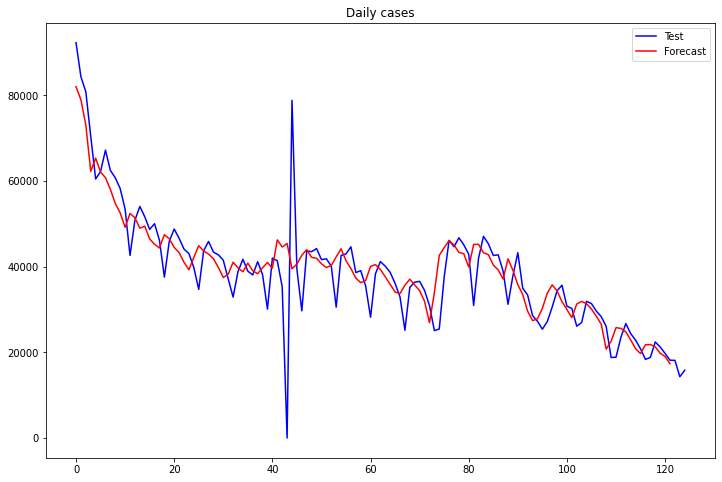

In [93]:
plot_fore_test(india_cases_test_scaled, yhat_uni_non_stacked_india_scaled, title='Daily cases')

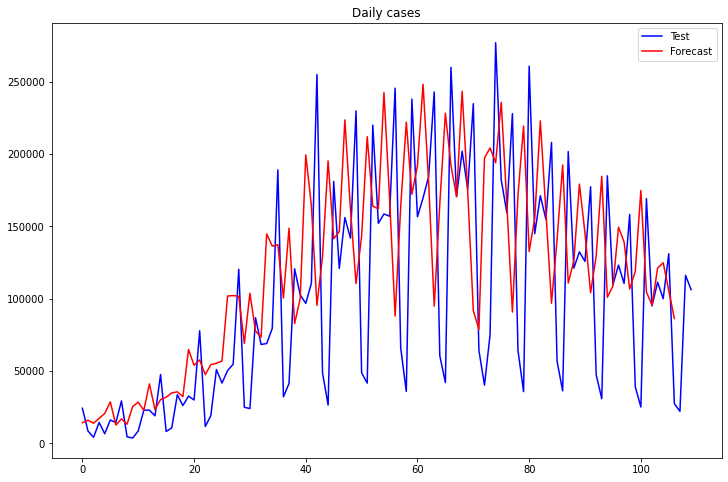

In [94]:
plot_fore_test(usa_cases_test_scaled, yhat_uni_non_stacked_usa_scaled, title='Daily cases')

In [97]:
india_cases_train_scaled.size

496

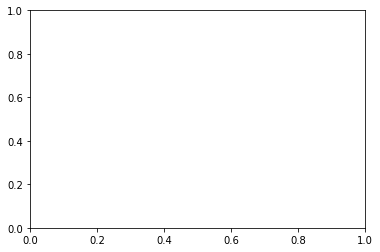

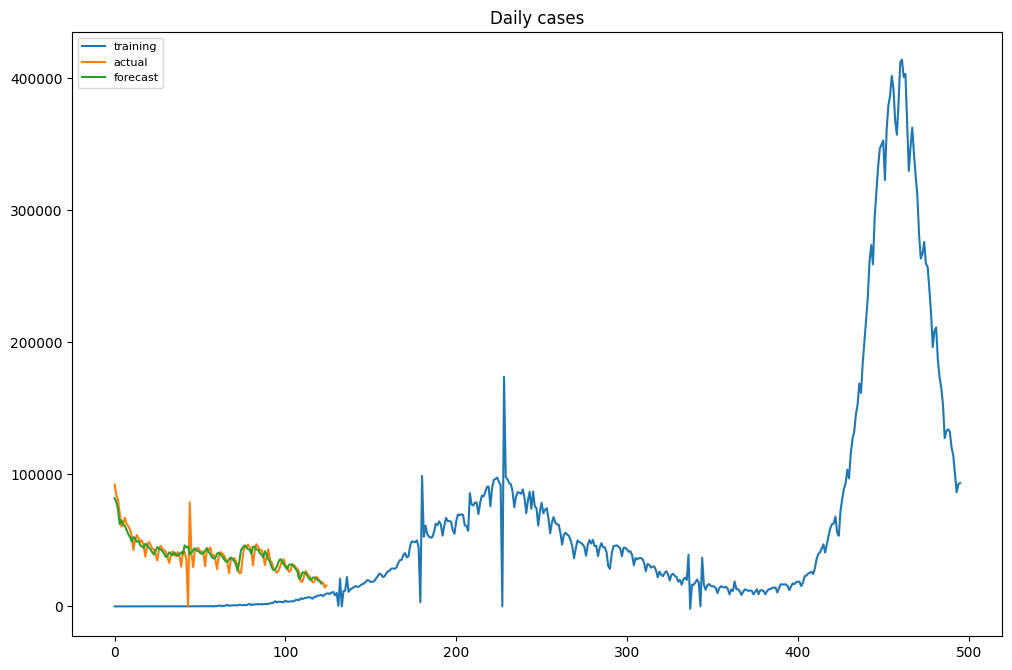

In [95]:
plot_fore(india_cases_train_scaled, india_cases_test_scaled, yhat_uni_non_stacked_india_scaled, title='Daily cases')

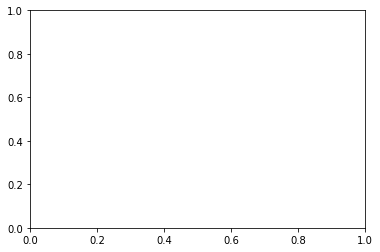

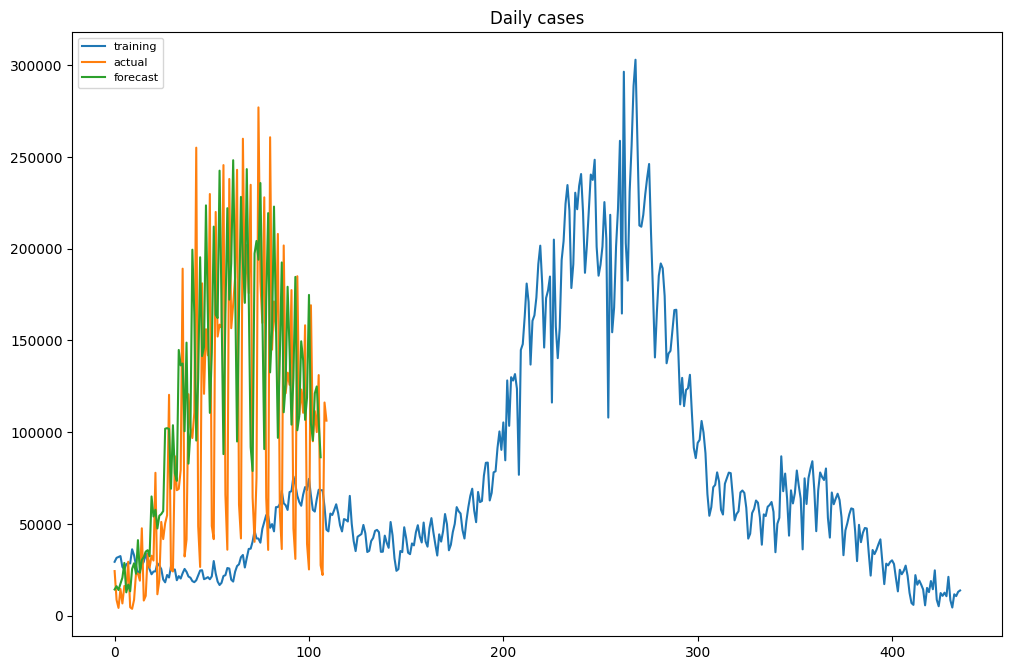

In [96]:
plot_fore(usa_cases_train_scaled, usa_cases_test_scaled, yhat_uni_non_stacked_usa_scaled, title='Daily cases')

### Univariate Non Stacked -- Long-Term

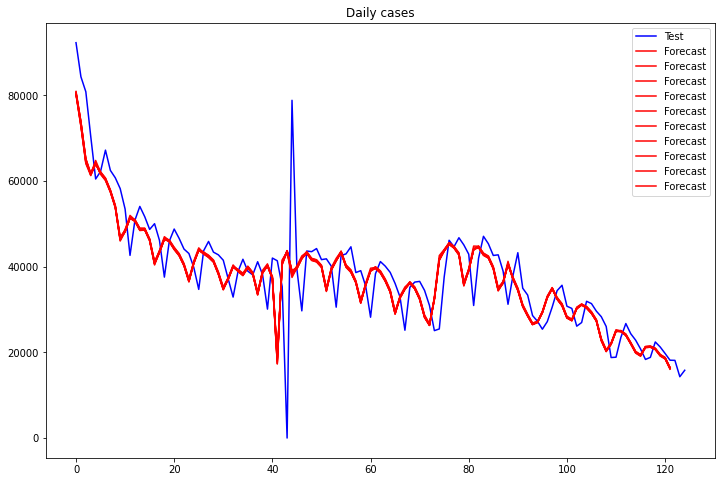

In [73]:
plot_fore_test(india_cases_test_scaled, yhat_uni_non_stacked_long_india_scaled, title='Daily cases')

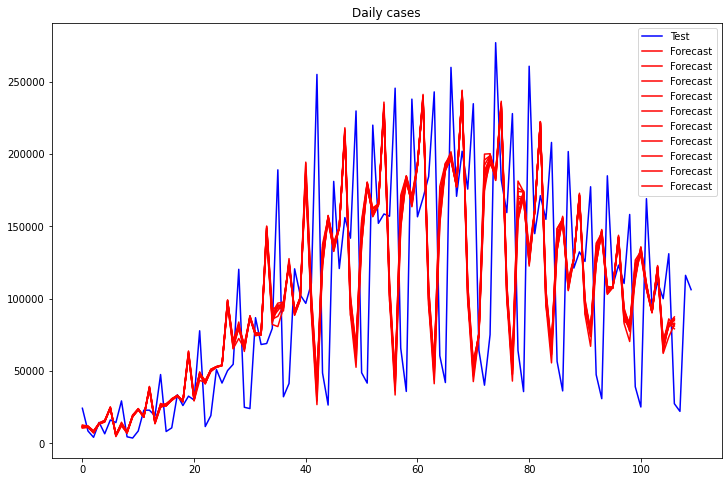

In [74]:
plot_fore_test(usa_cases_test_scaled, yhat_uni_non_stacked_long_usa_scaled, title='Daily cases')

### Univariate Stacked -- Rolling

In [ ]:
plot_fore_test(india_cases_test_scaled, yhat_uni_stacked_india_scaled, title='Daily cases')

In [ ]:
plot_fore_test(usa_cases_test_scaled, yhat_uni_stacked_usa_scaled, title='Daily cases')

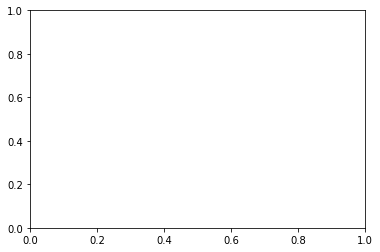

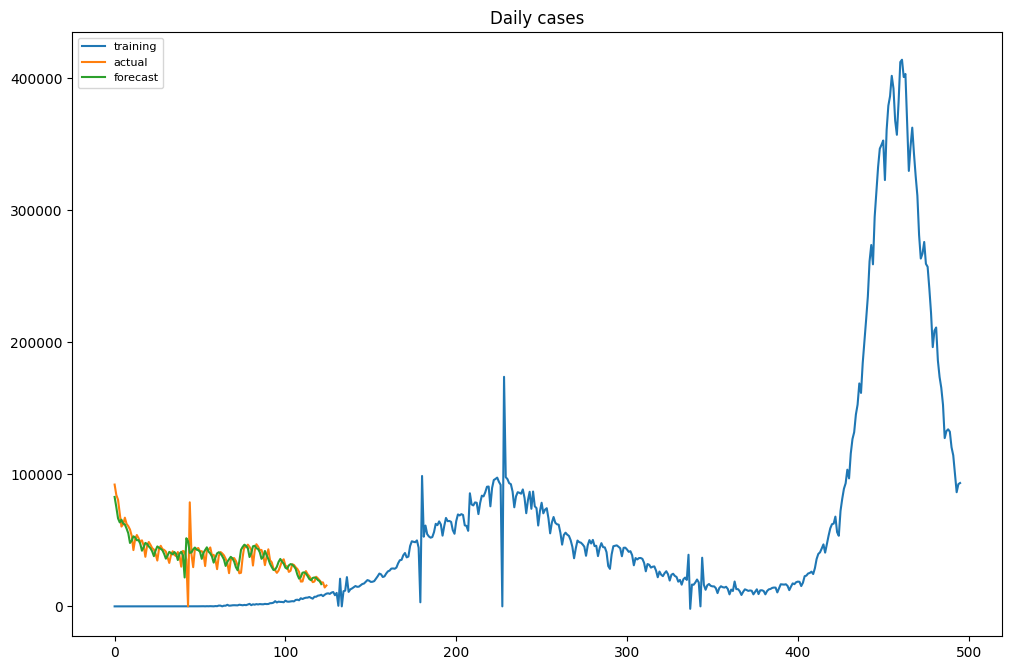

In [99]:
plot_fore(india_cases_train_scaled, india_cases_test_scaled, yhat_uni_stacked_india_scaled, title='Daily cases')

### Univariate Stacked -- Long-Term

In [ ]:
plot_fore_test(india_cases_test_scaled, yhat_uni_stacked_long_india_scaled, title='Daily cases')

In [ ]:
plot_fore_test(usa_cases_test_scaled, yhat_uni_stacked_long_usa_scaled, title='Daily cases')